# Machine Learning for Breast Cancer Treatment Response Prediction

# Import dataset on from my Kaggle input, and print the Pandas dataframe

In [51]:
import pandas as pd
import numpy as np


df = pd.read_excel("TrainDataset2025.xls", sheet_name = "Sheet1")

print(df)

            ID  pCR (outcome)  RelapseFreeSurvival (outcome)   Age  ER  PgR  \
0    TRG002174              1                     144.000000  41.0   0    0   
1    TRG002178              0                     142.000000  39.0   1    1   
2    TRG002204              1                     135.000000  31.0   0    0   
3    TRG002206              0                      12.000000  35.0   0    0   
4    TRG002210              0                     109.000000  61.0   1    0   
..         ...            ...                            ...   ...  ..  ...   
395  TRG002948              0                      54.500000  58.5   1    0   
396  TRG002954              0                      49.250000  34.3   0    0   
397  TRG002958              0                      48.500000  53.3   0    0   
398  TRG002961              0                      47.500000  68.8   1    0   
399  TRG002962              0                      46.916667  46.0   1    0   

     HER2  TrippleNegative  ChemoGrade  Proliferati

## We have 121 features and 400 datapoints -> curse of dimensionality

# Data Pre-processing Strategy

## Find Null Values, in this dataset it is marked as: 999

In [52]:
df == 999  # Returns boolean DataFrame

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
396,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
397,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
398,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Find number of Null 

In [53]:
(df == 999).sum()[lambda x: x > 0]

pCR (outcome)       5
PgR                 1
HER2                1
TrippleNegative     1
ChemoGrade          3
Proliferation       2
HistologyType       3
LNStatus            1
Gene               88
dtype: int64

 Data Pre-processing Strategy: Handling Missing Values

**Rationale:** Given the relatively small dataset size ($N=400$), aggressive row dropping would reduce statistical power and hurt model performance.

**Implementation Plan:**
1. **Replace:** Convert all instances of `999` to `np.NaN`.

2. **Imputation:** Attempt `SimpleImputer`and **`KNNImputer`** (k-Nearest Neighbors).
   * `KNNImputer` is prefereable as it estimates missing values based on similarity to other patients in the high-dimensional MRI feature space, which is generally more accurate for medical data than using a simple column mean.

   ### 2a. Baseline Approach: Simple Imputation
   **Methodology:**  
   In this baseline approach, we treat each feature independently.

    **Imputation:** Apply `SimpleImputer` using the **median** strategy.  
      * **Rationale:** Median is chosen over mean because it is more robust to outliers, which are common in medical survival datasets.  
      * **Hypothesis:** Provides a stable baseline but may miss complex relationships across the 100+ MRI radiomic features.

   ### 2b. Advanced Approach: K-Nearest Neighbors (KNN) Imputation
   **Methodology:**  
   This approach leverages correlations between MRI radiomic features to estimate missing values.

    **Imputation:** Apply `KNNImputer`.  
      * **Rationale:** Patients with similar tumor characteristics (MRI texture and intensity) likely share similar feature values.  
      * **Hypothesis:** Expected to yield **higher regression performance (lower MSE)** by preserving multivariate covariance structure.

## Replacing '999' with np.nan

In [54]:
# convert this to numpy's NaN format
df = df.replace(999, np.nan)

# Outcome to predict (RFS)
y = df['RelapseFreeSurvival (outcome)']

# Not imputing the ID or the Target columns (pCR, RelapseFreeSurvival)
X = df.drop(columns=['ID', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)'])

## Simple Imputer using Median

In [55]:
from sklearn.impute import SimpleImputer

imputer_simple = SimpleImputer(missing_values=np.nan, strategy='median')

# this learns the median from X and fills the NANs.
X_imputed_array_simple = imputer_simple.fit_transform(X) 

# converting numpy array convert it back to a DF.
X_imputed_simple = pd.DataFrame(X_imputed_array_simple, columns=X.columns)

# verification
print(f"Missing values before imputation: {df.isna().sum().sum()}")
print(f"Missing values after imputation:  {X_imputed_simple.isna().sum().sum()}")

Missing values before imputation: 105
Missing values after imputation:  0


## KNN imputer

In [56]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

# this learns from neighboring samples and fills the NANs
X_imputed_array_knn = knn_imputer.fit_transform(X)

# converting numpy array back to a DF
X_imputed_knn = pd.DataFrame(X_imputed_array_knn, columns=X.columns)

# verification
print(f"Missing values before imputation: {df.isna().sum().sum()}")
print(f"Missing values after imputation:  {X_imputed_knn.isna().sum().sum()}")

Missing values before imputation: 105
Missing values after imputation:  0


## Visualisation of the data (Simple imputer)

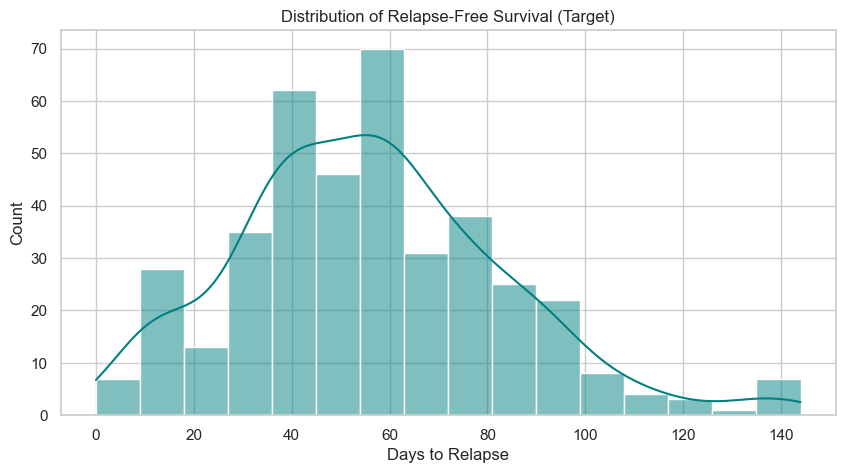

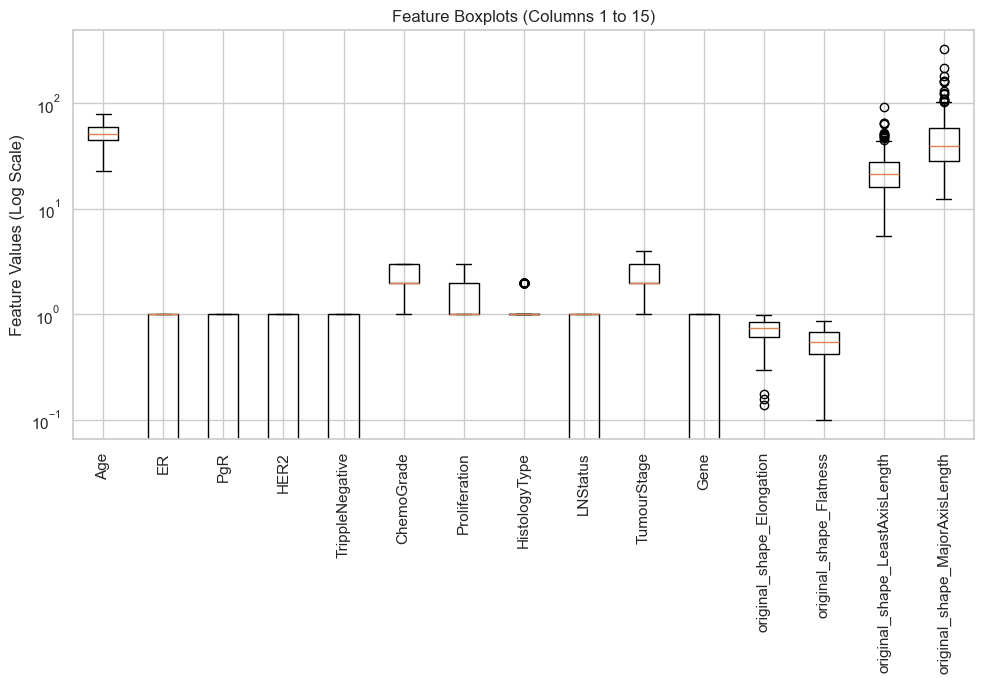

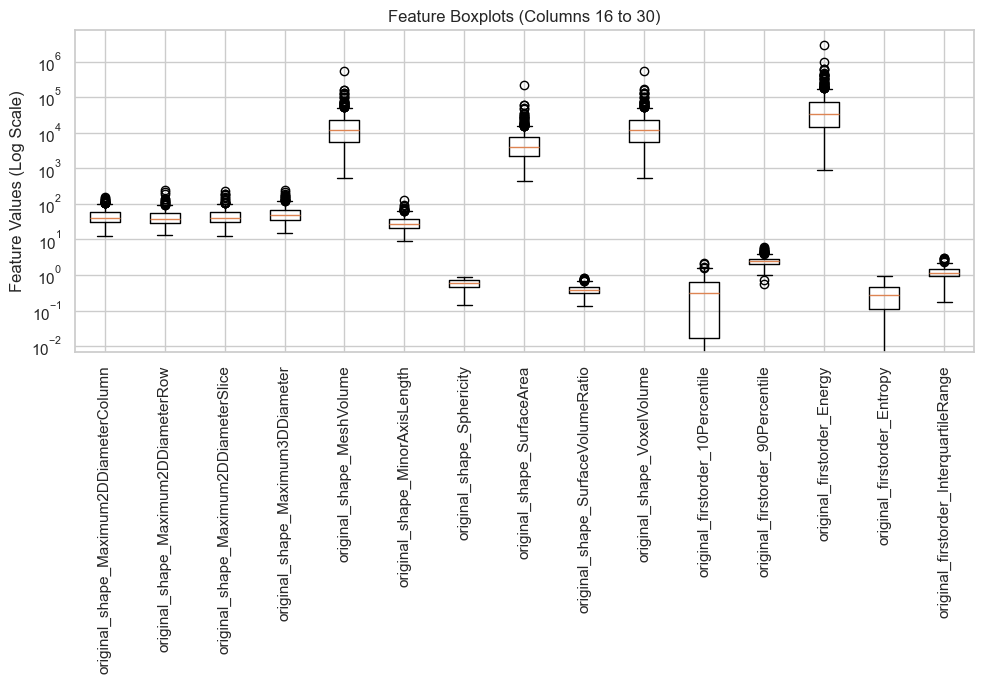

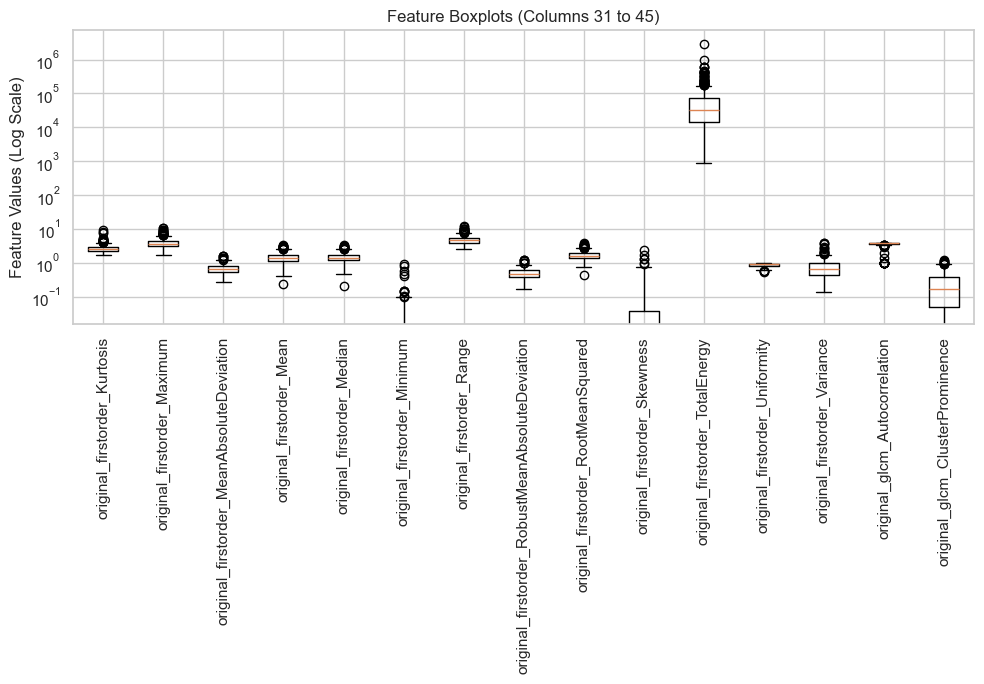

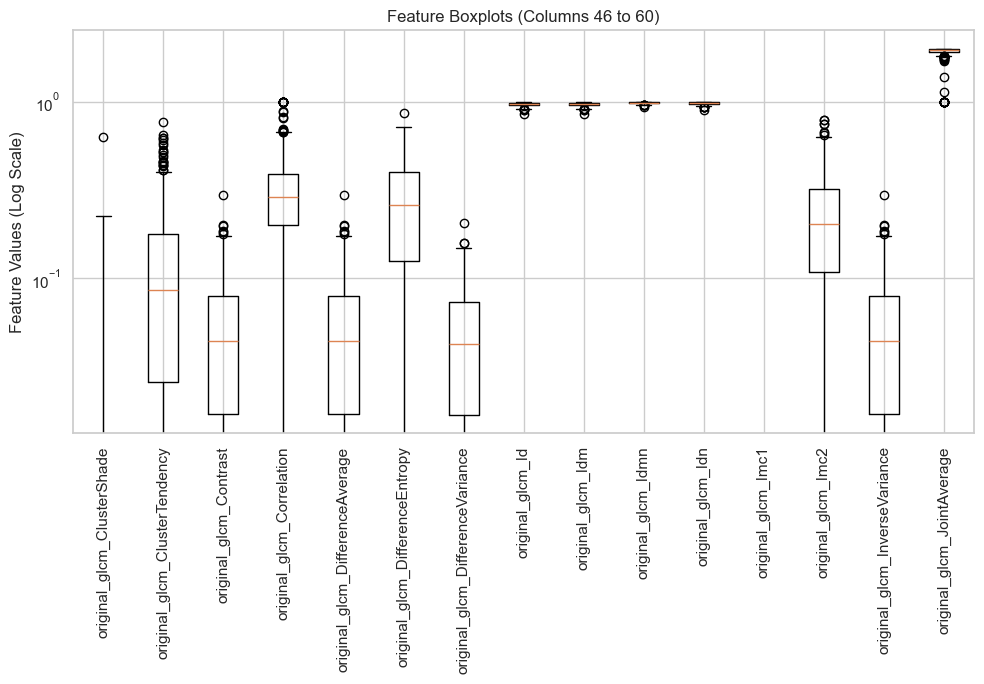

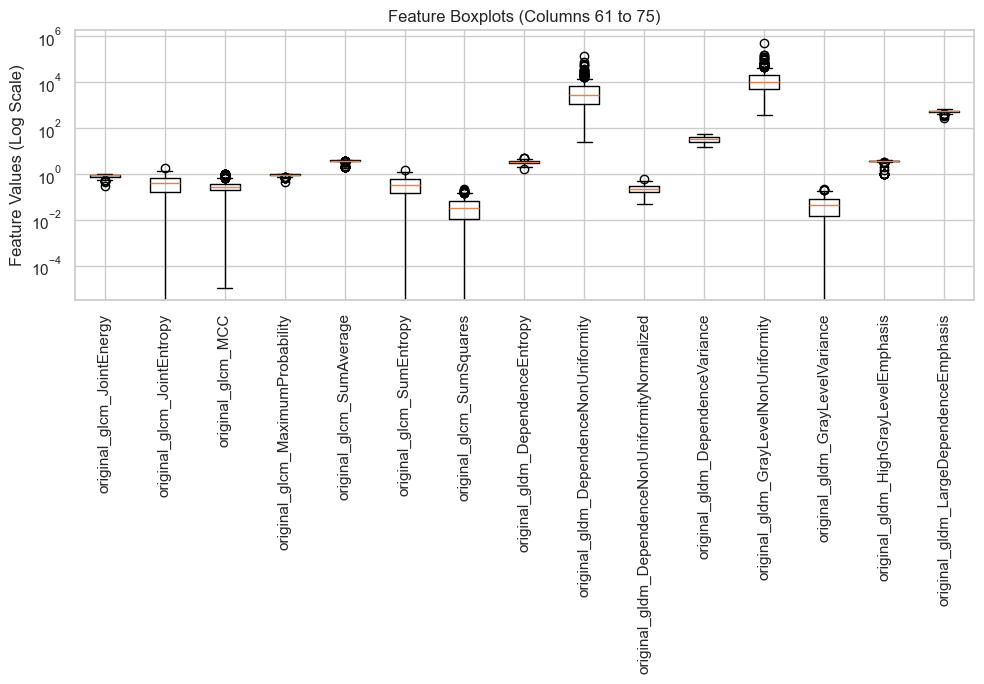

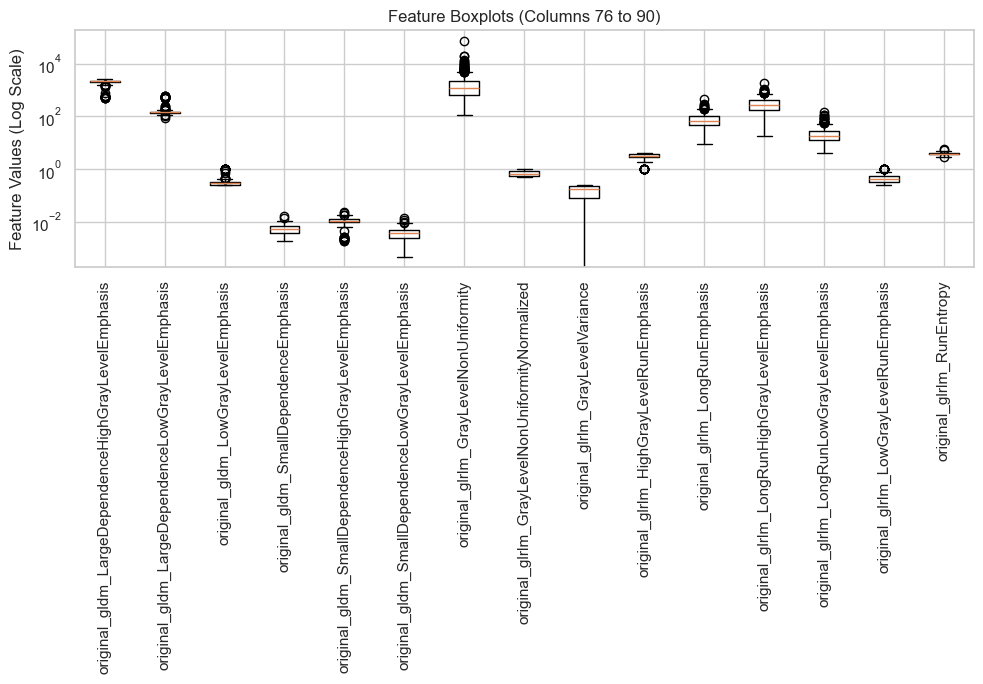

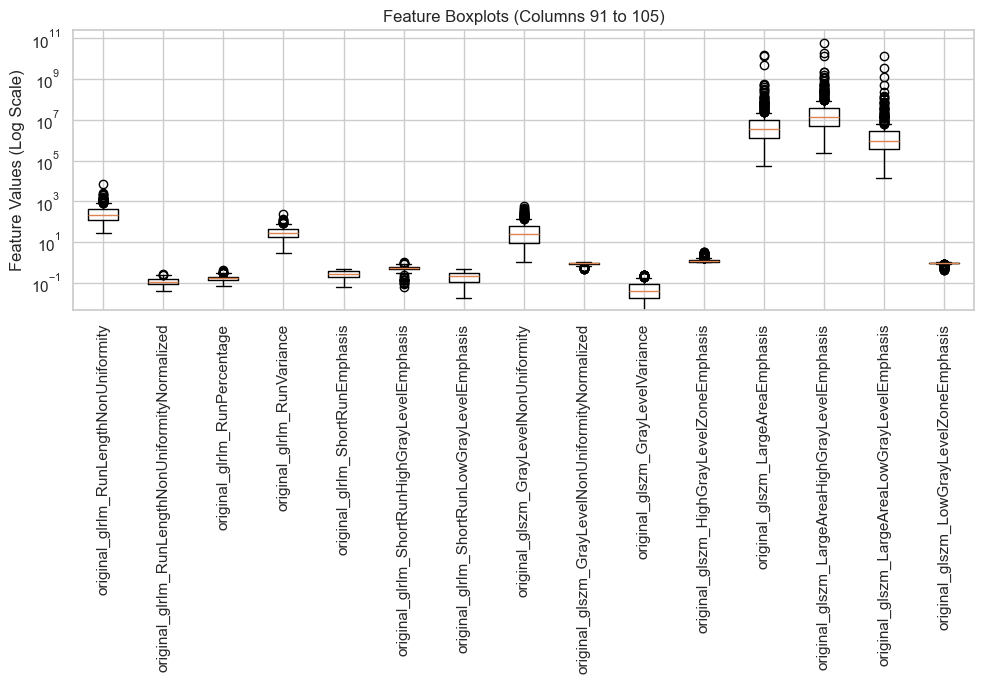

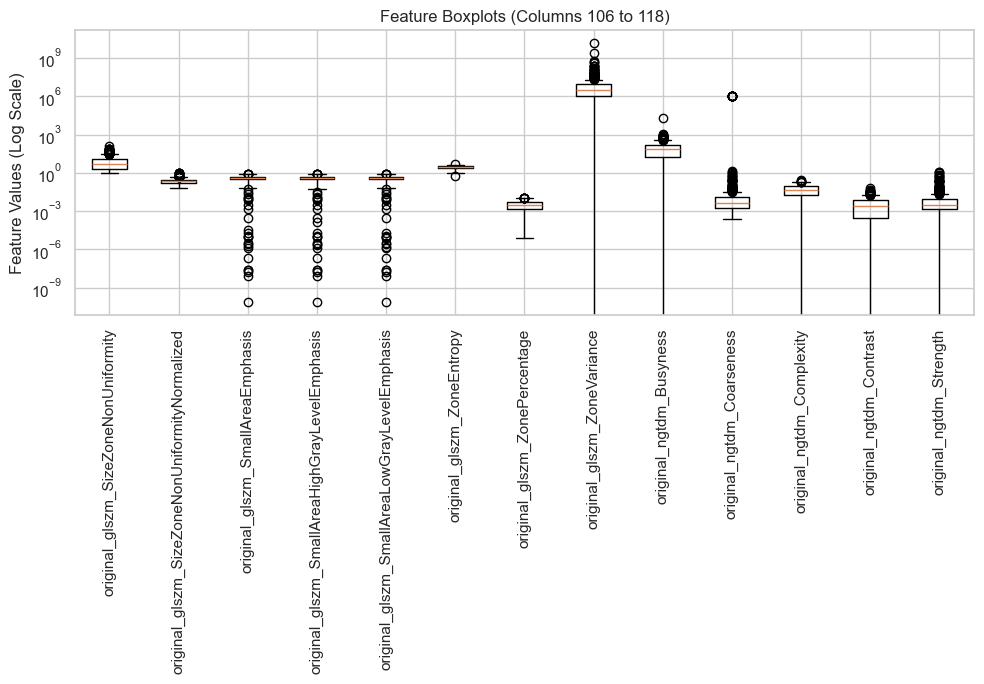

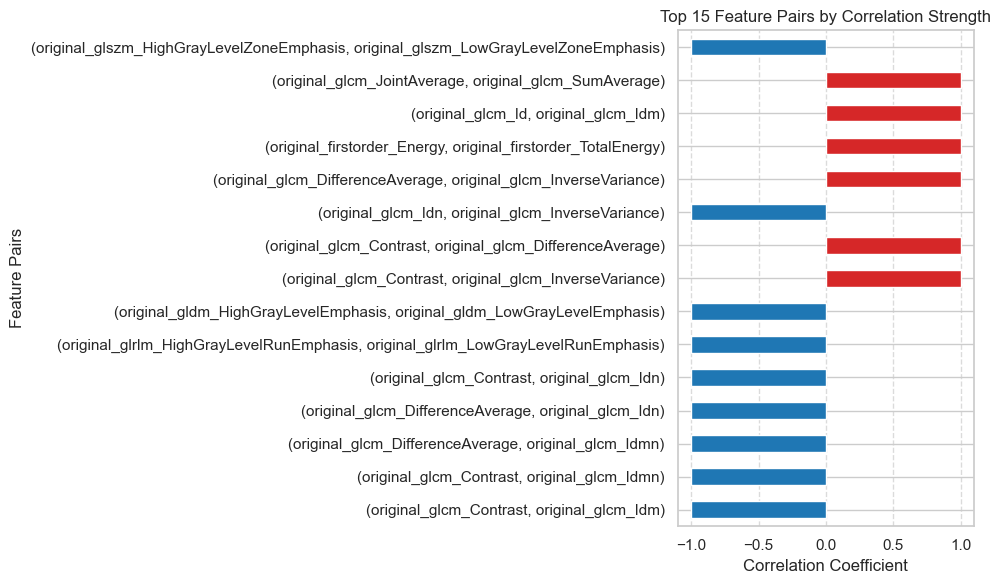

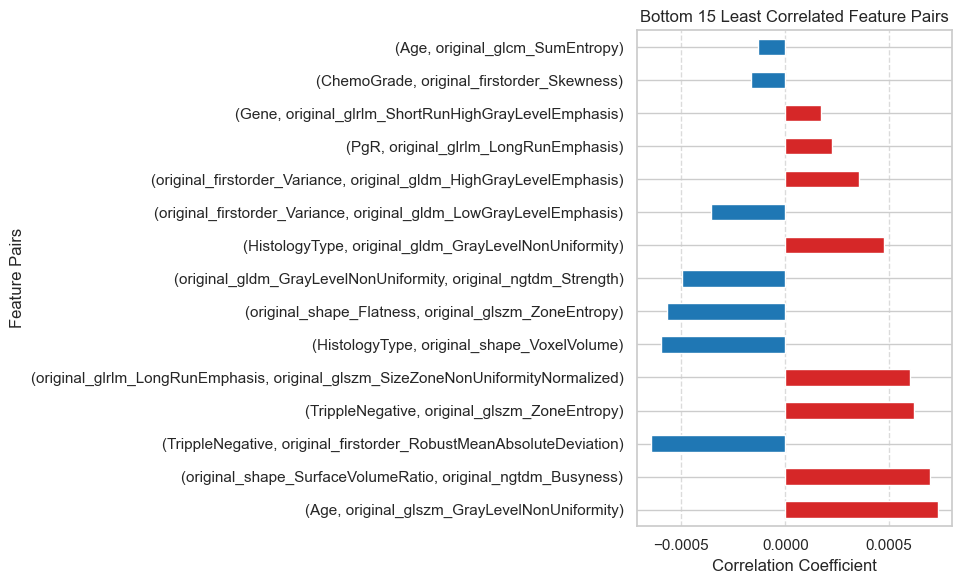

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True, color='teal') 
plt.title('Distribution of Relapse-Free Survival (Target)')
plt.xlabel('Days to Relapse')
plt.show()


cols = X_imputed_simple.columns
batch_size = 15  # adjustable

for i in range(0, len(cols), batch_size):
    batch = cols[i:i+batch_size]
    plt.figure(figsize=(10, 7))
    plt.boxplot([X_imputed_simple[c] for c in batch], labels=batch)
    plt.xticks(rotation=90)
    plt.yscale('log')
    plt.title(f'Feature Boxplots (Columns {i+1} to {i+len(batch)})')
    plt.ylabel('Feature Values (Log Scale)')
    plt.tight_layout()
    plt.show()


# preprocess for correlation strength
corr = X_imputed_simple.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_pairs = upper.stack().sort_values(key=abs, ascending=False) # Sort by absolute strength

# top 15
top_15 = corr_pairs.head(15)

plt.figure(figsize=(10, 6))

# color logic: red for positive, blue for negative
colors = ['#d62728' if x > 0 else '#1f77b4' for x in top_15.values]

# plot
top_15.plot(kind='barh', color=colors)
plt.title('Top 15 Feature Pairs by Correlation Strength')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature Pairs')
plt.gca().invert_yaxis() # Put the highest value at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# bottom 15 correlated pairs

# We take the tail (values closest to 0)
bottom_15 = corr_pairs.tail(15)

plt.figure(figsize=(10, 6))
colors = ['#d62728' if x > 0 else '#1f77b4' for x in bottom_15.values]

bottom_15.plot(kind='barh', color=colors)
plt.title('Bottom 15 Least Correlated Feature Pairs')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature Pairs')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [58]:
print(corr_pairs)

original_glszm_HighGrayLevelZoneEmphasis  original_glszm_LowGrayLevelZoneEmphasis        -1.000000
original_glcm_JointAverage                original_glcm_SumAverage                        1.000000
original_glcm_Id                          original_glcm_Idm                               1.000000
original_firstorder_Energy                original_firstorder_TotalEnergy                 1.000000
original_glcm_DifferenceAverage           original_glcm_InverseVariance                   1.000000
                                                                                            ...   
original_firstorder_Variance              original_gldm_HighGrayLevelEmphasis             0.000357
PgR                                       original_glrlm_LongRunEmphasis                  0.000223
Gene                                      original_glrlm_ShortRunHighGrayLevelEmphasis    0.000173
ChemoGrade                                original_firstorder_Skewness                   -0.000164
Age       

 Normalisation methods



## Z-score normalization

### Simple Imputer Scaling

In [59]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler (Z-score normalization)
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X_imputed_simple)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_imputed_simple.columns)

### KNN scaling

In [60]:
# StandardScaler (Z-score normalization) for KNNImputer
scaler_knn_standard = StandardScaler()
X_scaled_knn = scaler_knn_standard.fit_transform(X_imputed_knn)
X_scaled_knn_df = pd.DataFrame(X_scaled_knn, columns=X_imputed_knn.columns)

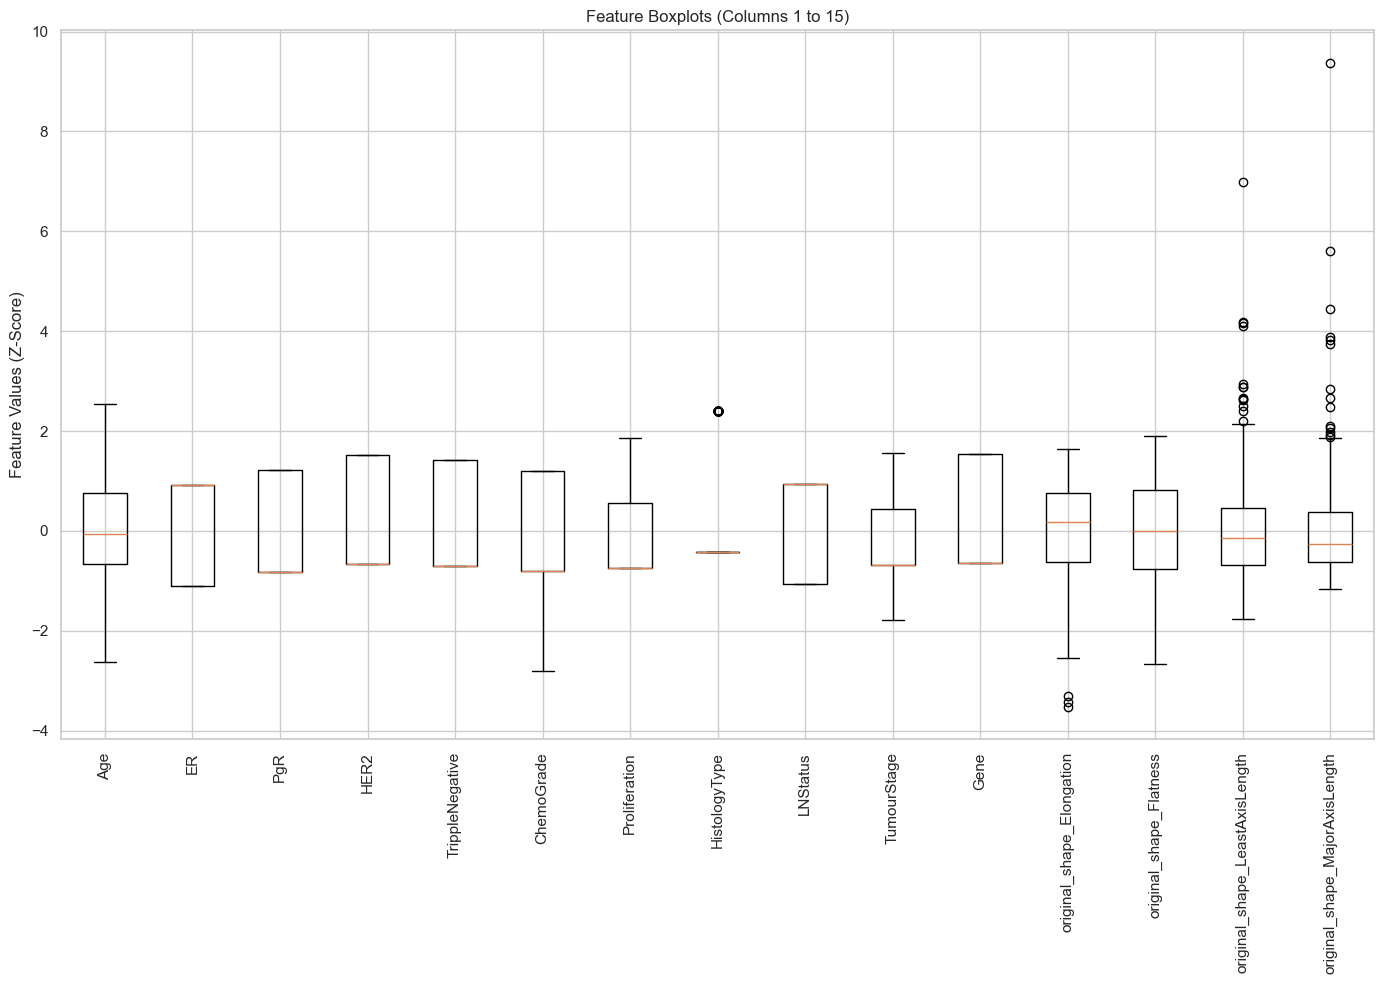

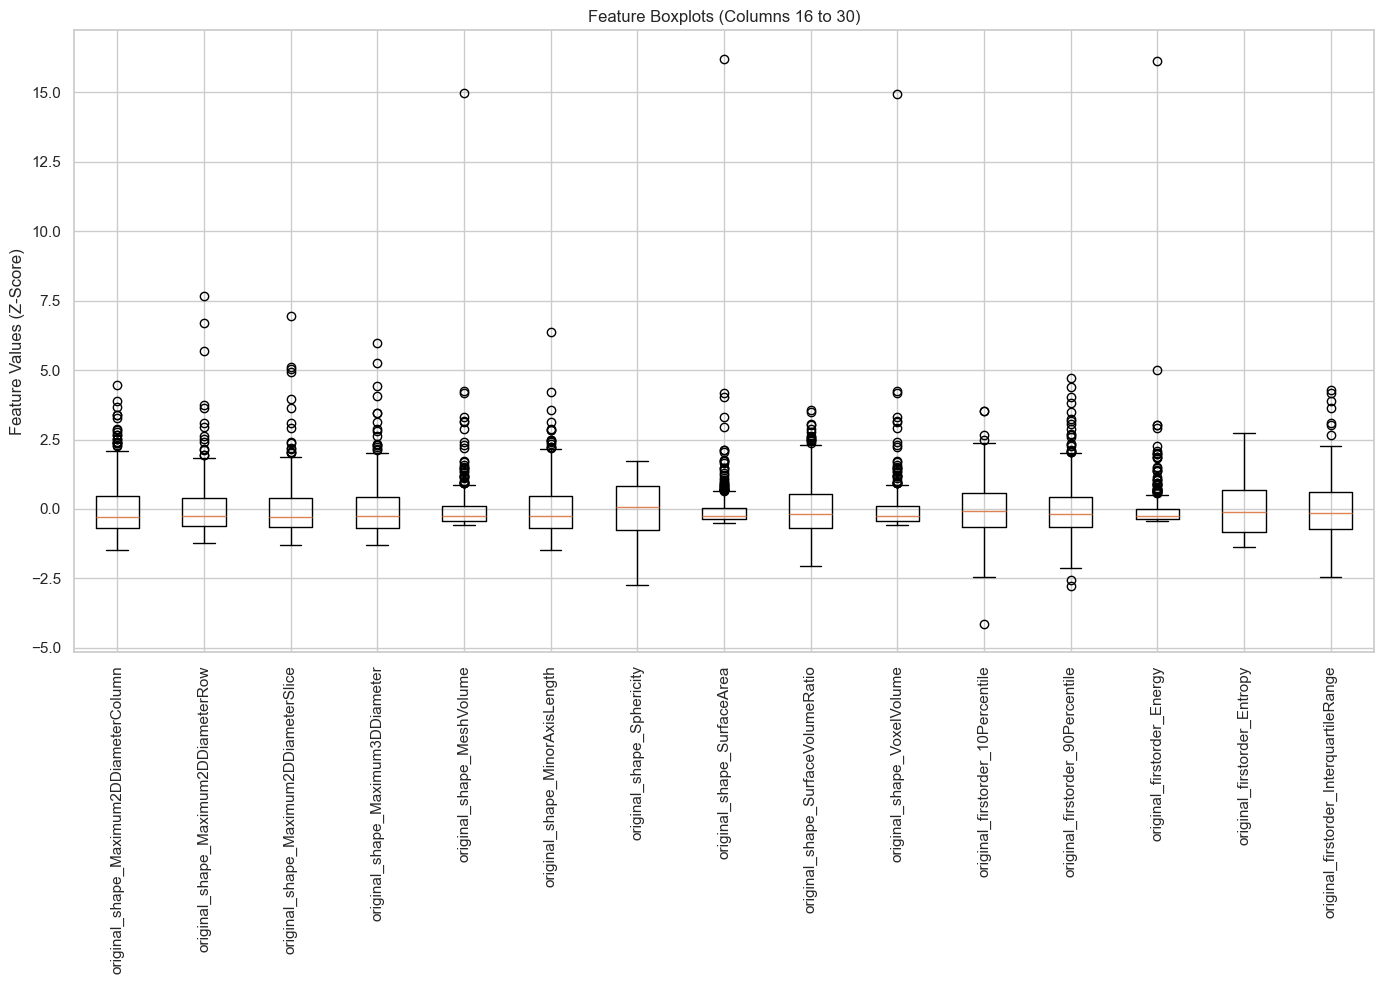

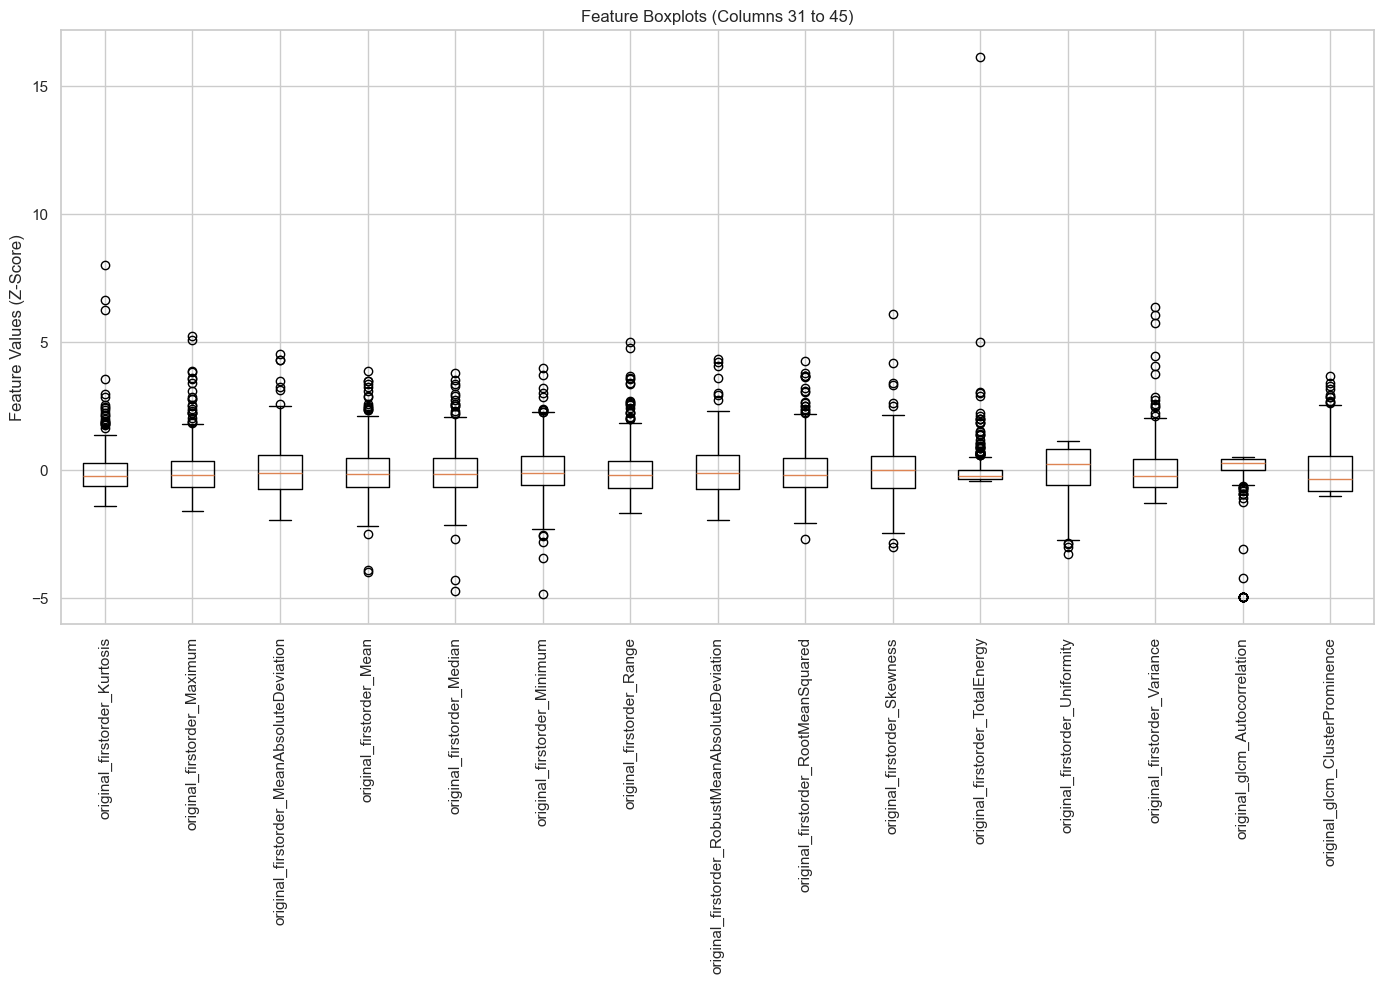

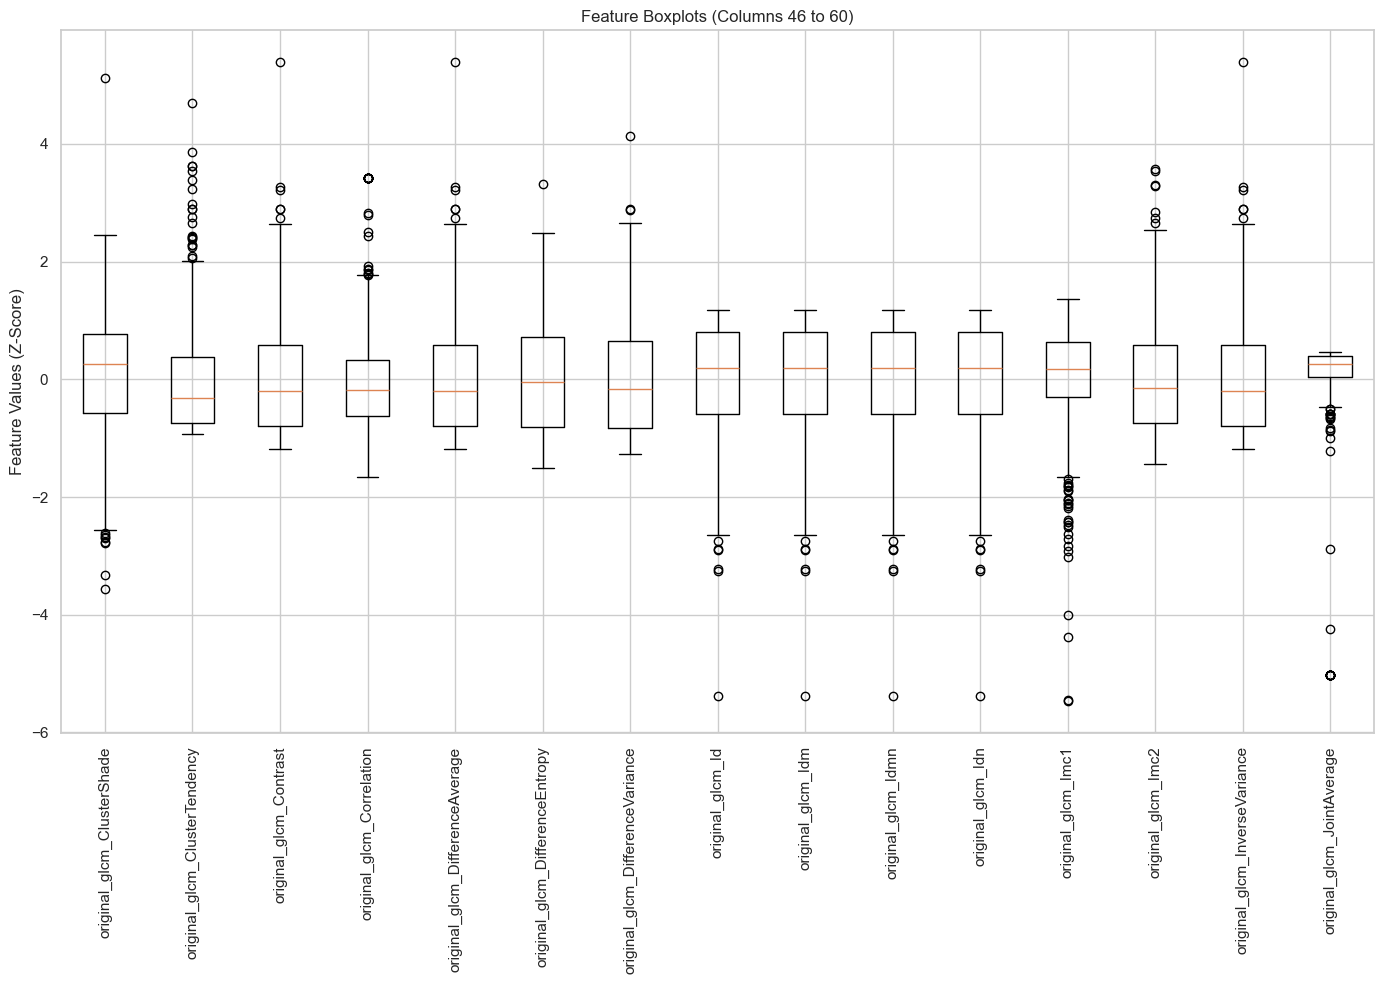

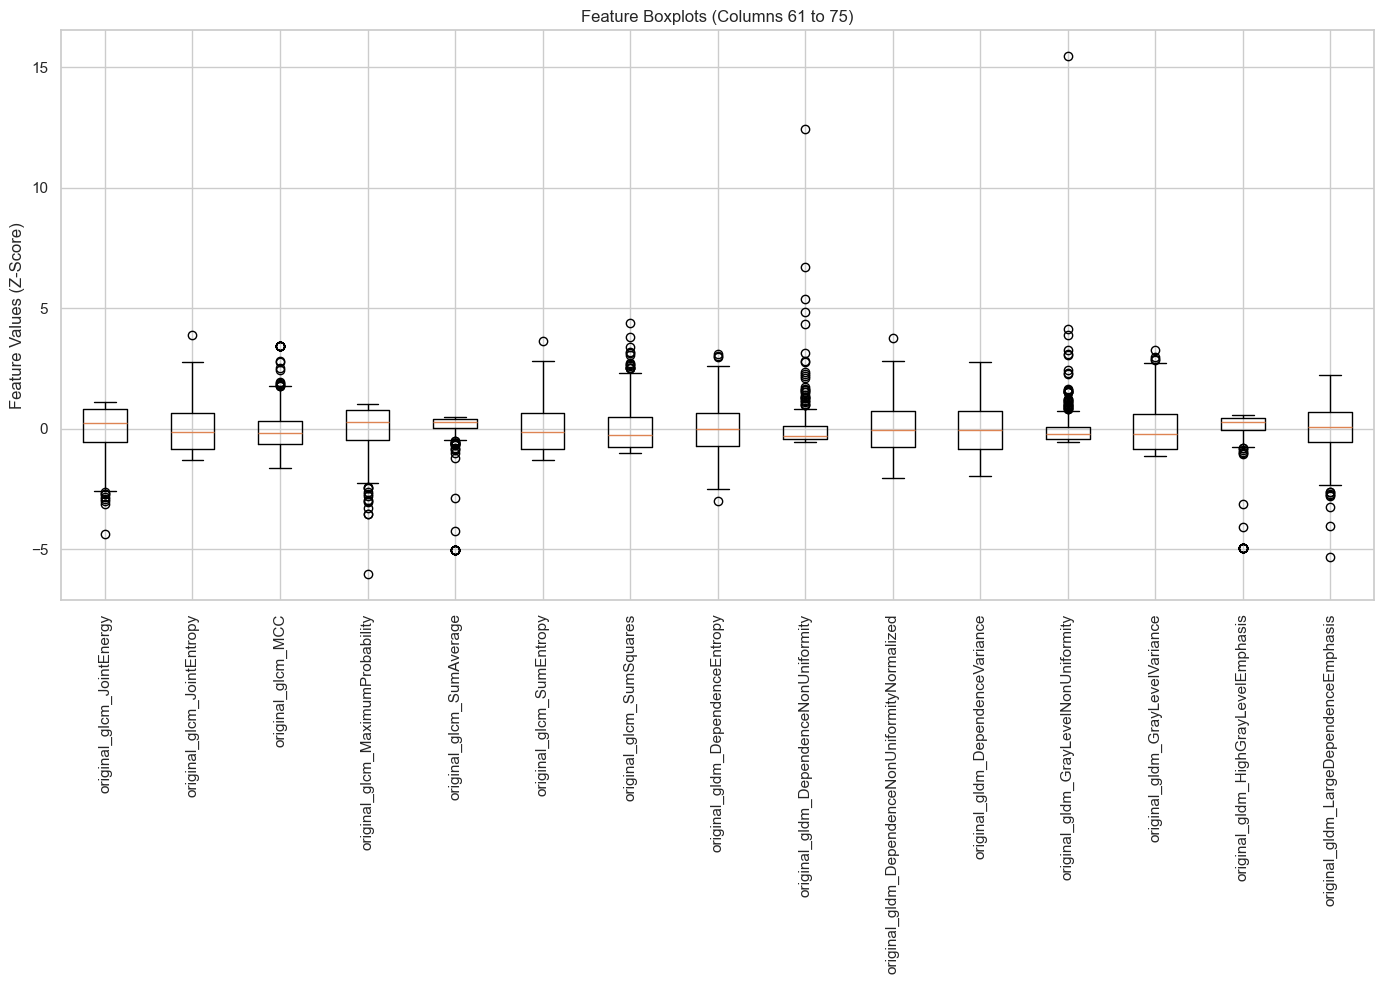

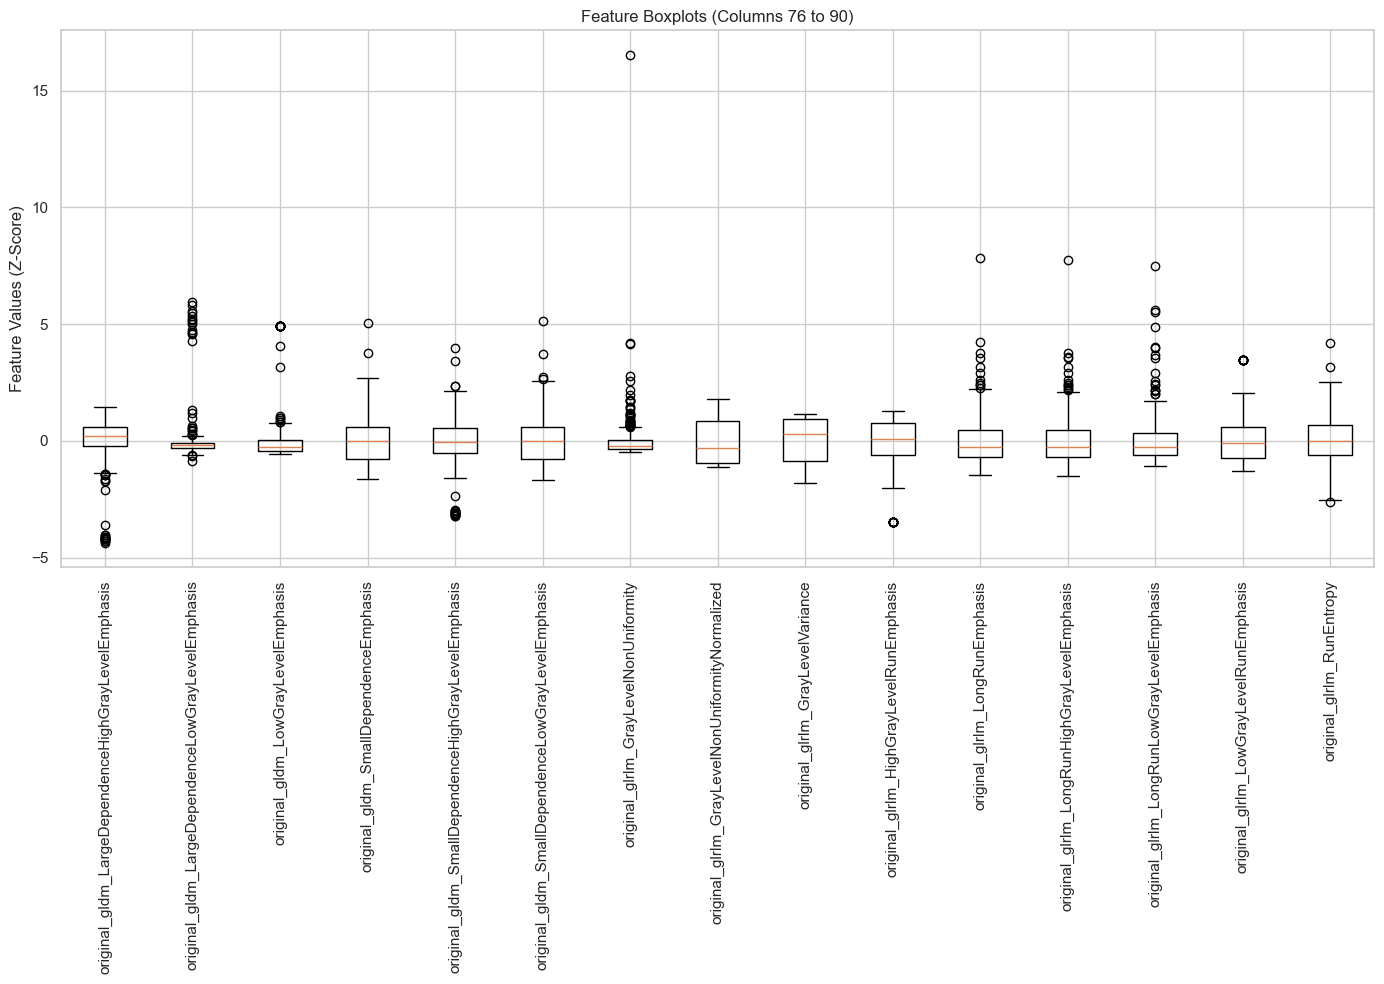

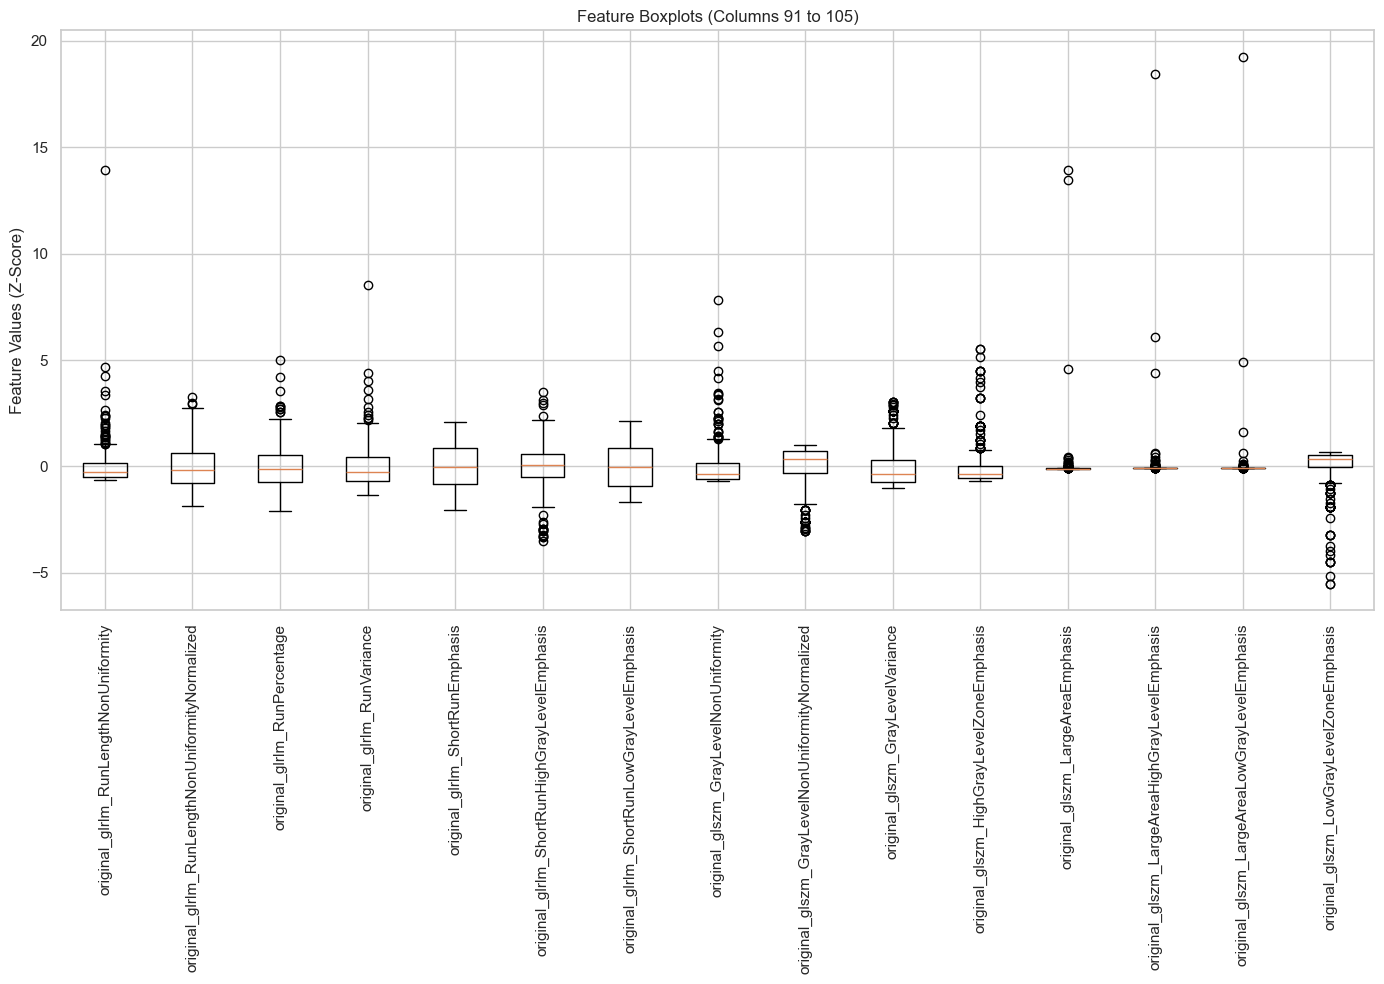

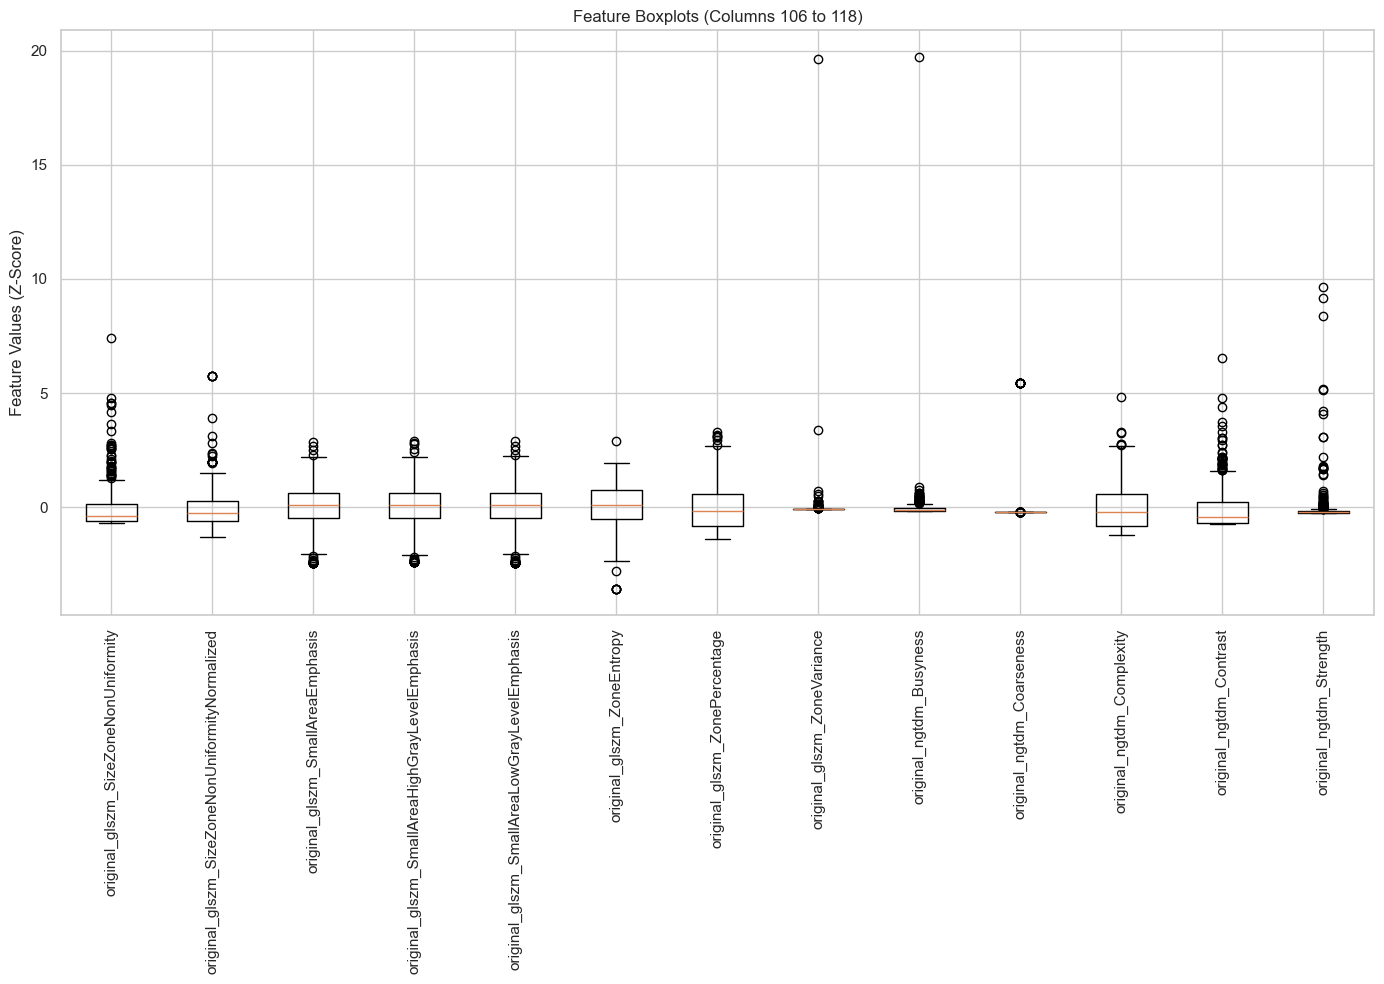

In [61]:
cols = X_scaled_df.columns
batch_size = 15

for i in range(0, len(cols), batch_size):
    batch = cols[i:i+batch_size]
    plt.figure(figsize=(14, 10))
    
    plt.boxplot([X_scaled_df[c] for c in batch], labels=batch)
    plt.xticks(rotation=90)
    
    # REMOVED: plt.yscale('log') <-- Use standard linear scale
    
    plt.title(f'Feature Boxplots (Columns {i+1} to {i+len(batch)})')
    plt.ylabel('Feature Values (Z-Score)') # Updated label
    plt.tight_layout()
    plt.show()

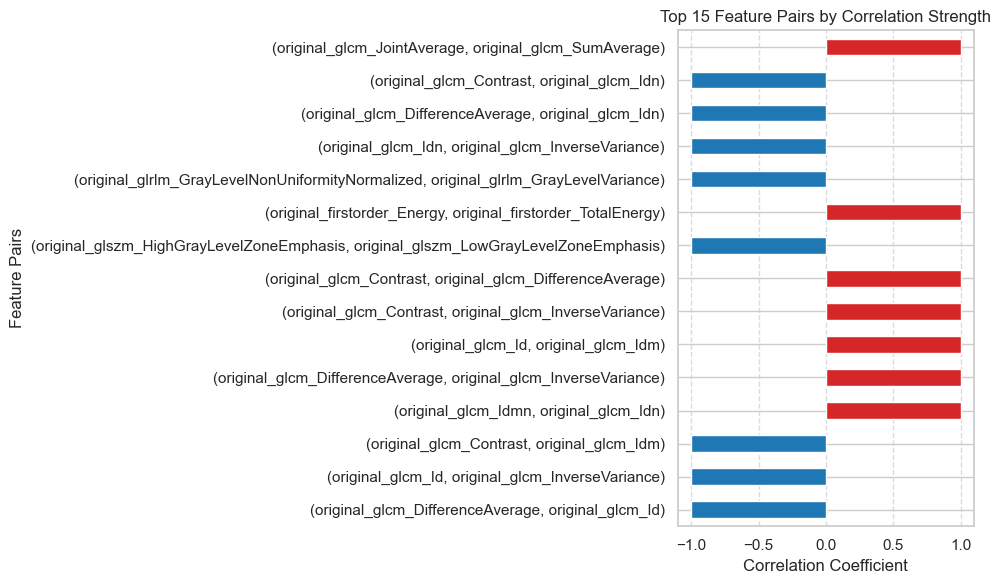

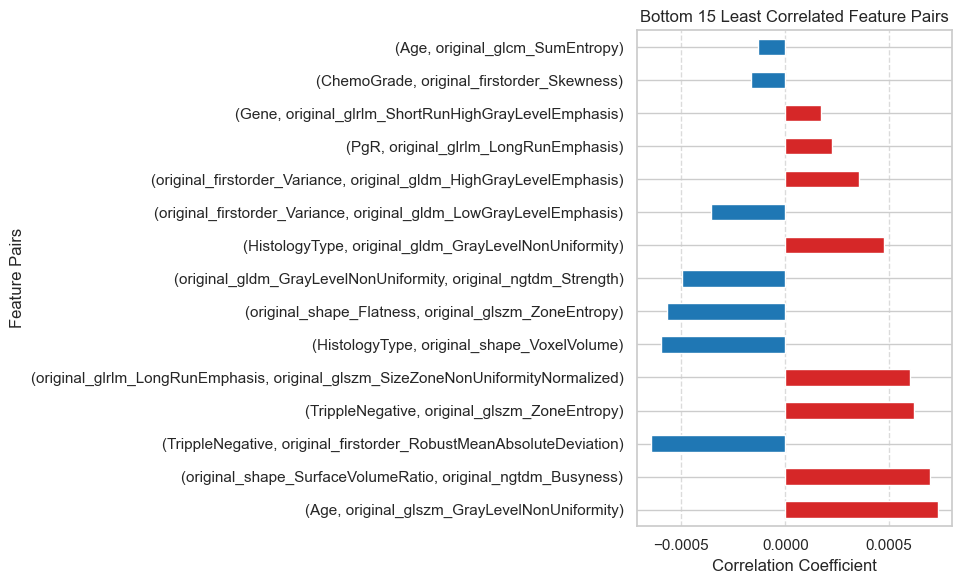

In [62]:
# preprocess for correlation strength
corr = X_scaled_df.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_pairs = upper.stack().sort_values(key=abs, ascending=False) # Sort by absolute strength

# top 15
top_15 = corr_pairs.head(15)

plt.figure(figsize=(10, 6))

# color logic: red for positive, blue for negative
colors = ['#d62728' if x > 0 else '#1f77b4' for x in top_15.values]

# plot
top_15.plot(kind='barh', color=colors)
plt.title('Top 15 Feature Pairs by Correlation Strength')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature Pairs')
plt.gca().invert_yaxis() # Put the highest value at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# bottom 15 correlated pairs

# We take the tail (values closest to 0)
bottom_15 = corr_pairs.tail(15)

plt.figure(figsize=(10, 6))
colors = ['#d62728' if x > 0 else '#1f77b4' for x in bottom_15.values]

bottom_15.plot(kind='barh', color=colors)
plt.title('Bottom 15 Least Correlated Feature Pairs')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature Pairs')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Using RobustScaler

 ### RobustScaler is a scaling technique in Scikit-Learn that scales data using statistics that are robust to outliers.
 ### Unlike StandardScaler (which uses the Mean and Variance) or MinMaxScaler (which uses the Minimum and Maximum), RobustScaler uses the Median and the Interquartile Range (IQR).

In [63]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

# subtracts the median and scales according to the quantile range
scaler = RobustScaler()

X_scaled_Robust = scaler.fit_transform(X_imputed_simple)

# Convert back to DataFrame
X_scaled_df_robust = pd.DataFrame(X_scaled_Robust, columns=X_imputed_simple.columns)

### KNN Scaling

In [64]:
# RobustScaler for KNNImputer
scaler_knn_robust = RobustScaler()
X_scaled_knn_robust = scaler_knn_robust.fit_transform(X_imputed_knn)
X_scaled_knn_robust_df = pd.DataFrame(X_scaled_knn_robust, columns=X_imputed_knn.columns)


# Baseline Train / test

## Train/Test Split & Cross-Validation Setup

### Establishing baselines before feature selection to measure improvement.

In [65]:
## Train/Test Split & Cross-Validation Setup
# 
# Establishing baselines before feature selection to measure improvement.

In [66]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
TEST_SIZE = 0.2

In [67]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# MAE scorer (negative because sklearn maximizes scores)

## Define pipelines using existing datasets

In [68]:
pipelines = {
    'simple_unscaled': {
        'X': X_imputed_simple,
        'y': y,
        'description': 'SimpleImputer (Median) - No Scaling'
    },
    'simple_zscore': {
        'X': X_scaled_df,  # StandardScaler output
        'y': y,
        'description': 'SimpleImputer (Median) + StandardScaler'
    },
    'simple_robust': {
        'X': X_scaled_df_robust,  # RobustScaler output
        'y': y,
        'description': 'SimpleImputer (Median) + RobustScaler'
    },

    # KNNImputer variations
    'knn_unscaled': {
        'X': X_imputed_knn,
        'y': y,
        'description': 'KNNImputer (n_neighbors=5) - No Scaling'
    },
    'knn_zscore': {
        'X': X_scaled_knn_df,
        'y': y,
        'description': 'KNNImputer (n_neighbors=5) + StandardScaler'
    },
    'knn_robust': {
        'X': X_scaled_knn_robust_df,
        'y': y,
        'description': 'KNNImputer (n_neighbors=5) + RobustScaler'
    }
}

print("Preprocessing pipelines:")
for name, pipe in pipelines.items():
    print(f"  - {name}: {pipe['X'].shape} | {pipe['description']}")

Preprocessing pipelines:
  - simple_unscaled: (400, 118) | SimpleImputer (Median) - No Scaling
  - simple_zscore: (400, 118) | SimpleImputer (Median) + StandardScaler
  - simple_robust: (400, 118) | SimpleImputer (Median) + RobustScaler
  - knn_unscaled: (400, 118) | KNNImputer (n_neighbors=5) - No Scaling
  - knn_zscore: (400, 118) | KNNImputer (n_neighbors=5) + StandardScaler
  - knn_robust: (400, 118) | KNNImputer (n_neighbors=5) + RobustScaler


## Train/Test Split

In [69]:
splits = {}

for name, pipe in pipelines.items():
    X_train, X_test, y_train, y_test = train_test_split(
        pipe['X'], pipe['y'], 
        test_size=TEST_SIZE, 
        random_state=RANDOM_STATE
    )
    splits[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    print(f"{name}: Train={X_train.shape[0]}, Test={X_test.shape[0]}")

simple_unscaled: Train=320, Test=80
simple_zscore: Train=320, Test=80
simple_robust: Train=320, Test=80
knn_unscaled: Train=320, Test=80
knn_zscore: Train=320, Test=80
knn_robust: Train=320, Test=80


## Define Baseline Models

In [70]:
baseline_models = {
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso': Lasso(alpha=1.0, random_state=RANDOM_STATE, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
    'SVR': SVR(kernel='rbf', C=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

print(f"Models to evaluate: {list(baseline_models.keys())}")
print(f"Total combinations: {len(pipelines)} pipelines × {len(baseline_models)} models = {len(pipelines) * len(baseline_models)}")

Models to evaluate: ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'GradientBoosting', 'SVR', 'KNN']
Total combinations: 6 pipelines × 7 models = 42


## Cross-Validation on ALL Pipelines x ALL Models

In [71]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

all_results = []

print("Running 5-Fold Cross-Validation...")
print("=" * 70)

for pipe_name, split_data in splits.items():
    X_train = split_data['X_train']
    y_train = split_data['y_train']
    
    print(f"\n{pipelines[pipe_name]['description']}")
    print("-" * 50)
    
    for model_name, model in baseline_models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=mae_scorer)
        
        mean_mae = -cv_scores.mean()
        std_mae = cv_scores.std()
        
        all_results.append({
            'Pipeline': pipe_name,
            'Model': model_name,
            'CV_MAE_Mean': mean_mae,
            'CV_MAE_Std': std_mae,
            'Description': pipelines[pipe_name]['description']
        })
        
        print(f"  {model_name:18} | MAE: {mean_mae:7.2f} ± {std_mae:.2f}")

Running 5-Fold Cross-Validation...

SimpleImputer (Median) - No Scaling
--------------------------------------------------
  Ridge              | MAE:   33.21 ± 18.59
  Lasso              | MAE:   30.58 ± 15.74
  ElasticNet         | MAE:   31.24 ± 17.11
  RandomForest       | MAE:   20.94 ± 1.45
  GradientBoosting   | MAE:   22.09 ± 1.04
  SVR                | MAE:   21.69 ± 1.83
  KNN                | MAE:   24.38 ± 3.20

SimpleImputer (Median) + StandardScaler
--------------------------------------------------
  Ridge              | MAE:   25.38 ± 4.15
  Lasso              | MAE:   21.07 ± 1.70
  ElasticNet         | MAE:   21.12 ± 1.56
  RandomForest       | MAE:   20.96 ± 1.43
  GradientBoosting   | MAE:   21.92 ± 1.13
  SVR                | MAE:   21.69 ± 1.67
  KNN                | MAE:   22.00 ± 1.91

SimpleImputer (Median) + RobustScaler
--------------------------------------------------
  Ridge              | MAE:   37.25 ± 25.39
  Lasso              | MAE:   25.28 ± 7.31
  E

## Results Summary

In [72]:
results_df = pd.DataFrame(all_results)

best_idx = results_df['CV_MAE_Mean'].idxmin()
best_result = results_df.loc[best_idx]

print("\n" + "=" * 70)
print("BASELINE RESULTS SUMMARY (All 118 Features)")
print("=" * 70)

print(f"\n BEST CONFIGURATION:")
print(f"   Pipeline: {best_result['Description']}")
print(f"   Model: {best_result['Model']}")
print(f"   CV MAE: {best_result['CV_MAE_Mean']:.2f} ± {best_result['CV_MAE_Std']:.2f}")

print(f"\n Best Model per Pipeline:")
print("-" * 50)
for pipe_name in pipelines.keys():
    pipe_results = results_df[results_df['Pipeline'] == pipe_name]
    best_pipe = pipe_results.loc[pipe_results['CV_MAE_Mean'].idxmin()]
    print(f"  {pipe_name:18} | {best_pipe['Model']:15} | MAE: {best_pipe['CV_MAE_Mean']:.2f}")

print(f"\n Best Pipeline per Model:")
print("-" * 50)
for model_name in baseline_models.keys():
    model_results = results_df[results_df['Model'] == model_name]
    best_model = model_results.loc[model_results['CV_MAE_Mean'].idxmin()]
    print(f"  {model_name:18} | {best_model['Pipeline']:18} | MAE: {best_model['CV_MAE_Mean']:.2f}")


BASELINE RESULTS SUMMARY (All 118 Features)

 BEST CONFIGURATION:
   Pipeline: SimpleImputer (Median) + RobustScaler
   Model: RandomForest
   CV MAE: 20.93 ± 1.45

 Best Model per Pipeline:
--------------------------------------------------
  simple_unscaled    | RandomForest    | MAE: 20.94
  simple_zscore      | RandomForest    | MAE: 20.96
  simple_robust      | RandomForest    | MAE: 20.93
  knn_unscaled       | RandomForest    | MAE: 21.05
  knn_zscore         | RandomForest    | MAE: 20.93
  knn_robust         | RandomForest    | MAE: 21.05

 Best Pipeline per Model:
--------------------------------------------------
  Ridge              | simple_zscore      | MAE: 25.38
  Lasso              | simple_zscore      | MAE: 21.07
  ElasticNet         | simple_zscore      | MAE: 21.12
  RandomForest       | simple_robust      | MAE: 20.93
  GradientBoosting   | simple_zscore      | MAE: 21.92
  SVR                | simple_zscore      | MAE: 21.69
  KNN                | knn_zscore    

## Visualization - Heatmap

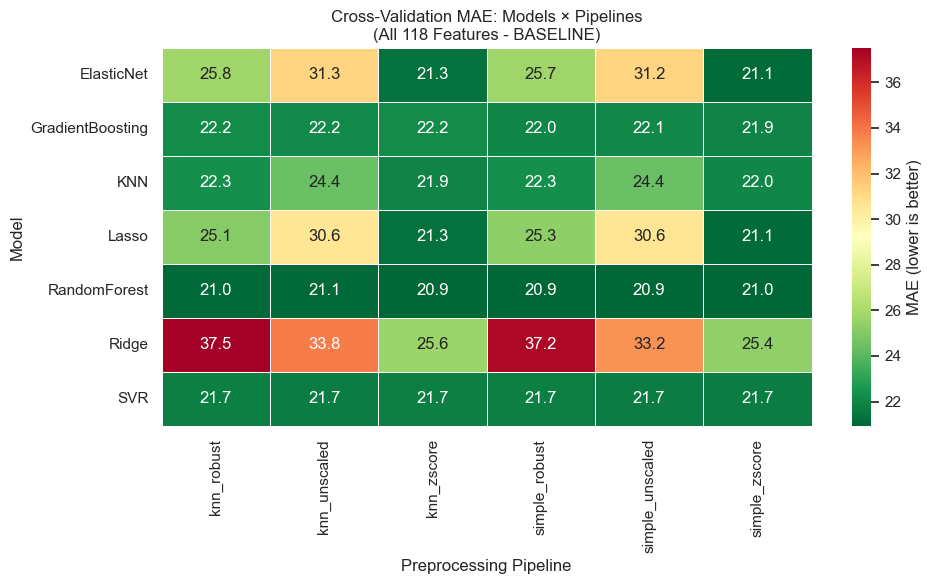

In [73]:
pivot_df = results_df.pivot(index='Model', columns='Pipeline', values='CV_MAE_Mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'MAE (lower is better)'})
plt.title('Cross-Validation MAE: Models × Pipelines\n(All 118 Features - BASELINE)')
plt.xlabel('Preprocessing Pipeline')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

## Test Set Evaluation (Best Configuration)

In [74]:
best_pipe_name = best_result['Pipeline']
best_model_name = best_result['Model']

X_train_best = splits[best_pipe_name]['X_train']
X_test_best = splits[best_pipe_name]['X_test']
y_train_best = splits[best_pipe_name]['y_train']
y_test_best = splits[best_pipe_name]['y_test']

# Clone and train best model
best_model = baseline_models[best_model_name].__class__(**baseline_models[best_model_name].get_params())
best_model.fit(X_train_best, y_train_best)

y_pred_test = best_model.predict(X_test_best)
test_mae = mean_absolute_error(y_test_best, y_pred_test)

print("=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)
print(f"Pipeline: {pipelines[best_pipe_name]['description']}")
print(f"Model: {best_model_name}")
print(f"CV MAE: {best_result['CV_MAE_Mean']:.2f} ± {best_result['CV_MAE_Std']:.2f}")
print(f"Test MAE: {test_mae:.2f}")

TEST SET EVALUATION
Pipeline: SimpleImputer (Median) + RobustScaler
Model: RandomForest
CV MAE: 20.93 ± 1.45
Test MAE: 23.18


## Prediction vs Actual Plot

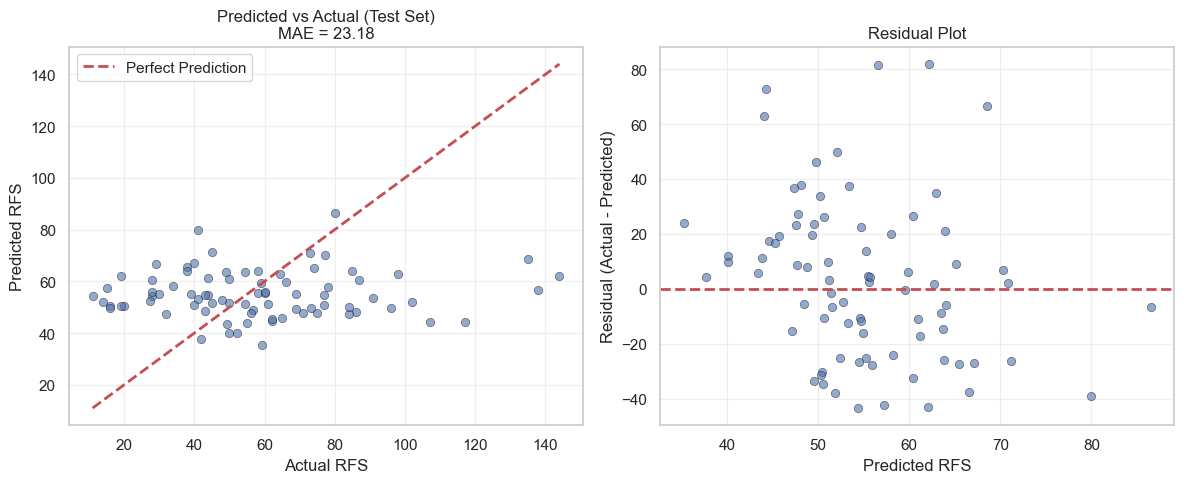

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Predicted vs Actual
axes[0].scatter(y_test_best, y_pred_test, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test_best.min(), y_test_best.max()], 
             [y_test_best.min(), y_test_best.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RFS')
axes[0].set_ylabel('Predicted RFS')
axes[0].set_title(f'Predicted vs Actual (Test Set)\nMAE = {test_mae:.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test_best - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted RFS')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Save Baseline for Comparison

In [76]:
BASELINE_BEST_MAE = best_result['CV_MAE_Mean']
BASELINE_BEST_PIPELINE = best_pipe_name
BASELINE_BEST_MODEL = best_model_name

print("\n" + "=" * 70)
print("✓ BASELINE ESTABLISHED")
print("=" * 70)
print(f"Baseline MAE to beat: {BASELINE_BEST_MAE:.2f}")
print(f"Features used: {X_train_best.shape[1]}")
print("\nNext: Feature Selection → Compare against this baseline")


✓ BASELINE ESTABLISHED
Baseline MAE to beat: 20.93
Features used: 118

Next: Feature Selection → Compare against this baseline


# Feature Selection / Dimensionality Reduction

## Why Feature Selection?

| Issue | Our Dataset |
|-------|-------------|
| Samples (N) | 400 |
| Features (p) | 118 |
| Ratio (N/p) | 3.4 |

With **N/p < 10**, we face the **curse of dimensionality** - risk of overfitting and poor generalisation. Feature selection will help improve model performance and interpretability.

## Constraint: Must-Keep Features

Per assignment requirements, the following features **must be retained**:
- **ER** (Estrogen Receptor)
- **HER2** (Human Epidermal Growth Factor Receptor 2)
- **Gene**

## Methods to Compare

### 1. Mutual Information (Filter Method)
- Measures statistical dependency between each feature and target (RFS)
- Captures **non-linear** relationships
- Fast, model-agnostic

### 2. Lasso Regression (Embedded Method)
- L1 regularisation drives irrelevant feature coefficients to **zero**
- Automatic feature selection during training
- Good for handling **multicollinearity** in radiomics features

### 3. Random Forest Importance (Embedded Method)
- Measures feature importance via mean decrease in impurity
- Handles **non-linear relationships** and **feature interactions**
- Robust to outliers, no scaling required

### 4. PCA Hybrid (Dimensionality Reduction)
- **Keep** all 11 clinical features (including ER, HER2, Gene)
- **Apply PCA** only to 107 radiomics features
- Compress radiomics into principal components while preserving clinical interpretability

## Evaluation Strategy

For each method, we will:
1. Select top **k** features (testing k = 10, 15, 20, 30, 40, 50)
2. Ensure ER, HER2, Gene are always included
3. Evaluate using **5-fold CV** with **MAE** metric
4. Compare against baseline (all 118 features)

In [77]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
import warnings
warnings.filterwarnings('ignore')

# YOUR WINNING PIPELINE DATA
X_fs = X_scaled_df_robust.copy()  # RobustScaler output
y_fs = y.copy()

# Must-keep features (per assignment requirement)
MUST_KEEP = ['ER', 'HER2', 'Gene']

# Baseline to beat
BASELINE_MAE = 20.91

# CV setup
RANDOM_STATE = 42
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

print(f"Dataset shape: {X_fs.shape}")
print(f"Must-keep features present: {all(f in X_fs.columns for f in MUST_KEEP)}")
print(f"Baseline MAE to beat: {BASELINE_MAE}")

Dataset shape: (400, 118)
Must-keep features present: True
Baseline MAE to beat: 20.91


## Identify Clinical vs Radiomics Features

In [78]:
# Clinical features (first 11 after dropping ID, pCR, RFS)
CLINICAL_FEATURES = ['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 
                     'ChemoGrade', 'Proliferation', 'HistologyType', 
                     'LymphNodeStatus', 'TumourStage', 'Gene']

# Radiomics features (all original_* columns)
RADIOMICS_FEATURES = [col for col in X_fs.columns if col.startswith('original_')]

print(f"Clinical features: {len(CLINICAL_FEATURES)}")
print(f"Radiomics features: {len(RADIOMICS_FEATURES)}")
print(f"Total: {len(CLINICAL_FEATURES) + len(RADIOMICS_FEATURES)}")

Clinical features: 11
Radiomics features: 107
Total: 118


## Helper Function - Select Features with Must-Keep Constraint


In [79]:
def select_features_with_mandatory(X, y, method, n_features, must_keep):
    """
    Select features while ensuring mandatory features are always included.
    
    Parameters:
    - X: feature DataFrame
    - y: target Series
    - method: 'mutual_info', 'lasso', 'rf_importance'
    - n_features: total number of features to select (including must_keep)
    - must_keep: list of feature names that must be retained
    
    Returns:
    - List of selected feature names
    """
    # Features available for selection (excluding must-keep)
    selectable_cols = [c for c in X.columns if c not in must_keep]
    X_selectable = X[selectable_cols]
    
    # Number of additional features to select
    n_additional = max(0, n_features - len(must_keep))
    
    if n_additional == 0:
        return must_keep.copy()
    
    if method == 'mutual_info':
        selector = SelectKBest(score_func=mutual_info_regression, k=n_additional)
        selector.fit(X_selectable, y)
        mask = selector.get_support()
        selected = [selectable_cols[i] for i, m in enumerate(mask) if m]
        
    elif method == 'lasso':
        lasso = LassoCV(cv=5, random_state=RANDOM_STATE, max_iter=10000)
        lasso.fit(X_selectable, y)
        importance = np.abs(lasso.coef_)
        top_idx = np.argsort(importance)[-n_additional:]
        selected = [selectable_cols[i] for i in top_idx]
        
    elif method == 'rf_importance':
        rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
        rf.fit(X_selectable, y)
        importance = rf.feature_importances_
        top_idx = np.argsort(importance)[-n_additional:]
        selected = [selectable_cols[i] for i in top_idx]
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Combine must-keep with selected
    final_features = must_keep + selected
    return final_features

## Method 1, 2, 3 - Filter & Embedded Methods


In [80]:
# Feature counts to test
K_VALUES = [10, 15, 20, 30, 40, 50]

# Methods to compare
METHODS = ['mutual_info', 'lasso', 'rf_importance']

# Model for evaluation (RandomForest - your baseline winner)
eval_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)

# Store results
fs_results = []

print("Evaluating Feature Selection Methods...")
print("=" * 70)

for method in METHODS:
    print(f"\n{method.upper()}")
    print("-" * 50)
    
    for k in K_VALUES:
        # Select features
        selected = select_features_with_mandatory(X_fs, y_fs, method, k, MUST_KEEP)
        X_selected = X_fs[selected]
        
        # Cross-validate
        scores = cross_val_score(eval_model, X_selected, y_fs, cv=cv, scoring=mae_scorer)
        mean_mae = -scores.mean()
        std_mae = scores.std()
        
        # Compare to baseline
        improvement = BASELINE_MAE - mean_mae
        
        fs_results.append({
            'Method': method,
            'K': k,
            'MAE': mean_mae,
            'Std': std_mae,
            'Improvement': improvement,
            'Features': selected
        })
        
        status = "✓ BETTER" if improvement > 0 else "✗ WORSE"
        print(f"  k={k:2d} | MAE: {mean_mae:.2f} ± {std_mae:.2f} | Δ: {improvement:+.2f} {status}")

Evaluating Feature Selection Methods...

MUTUAL_INFO
--------------------------------------------------
  k=10 | MAE: 22.05 ± 2.20 | Δ: -1.14 ✗ WORSE
  k=15 | MAE: 21.55 ± 1.66 | Δ: -0.64 ✗ WORSE
  k=20 | MAE: 21.15 ± 1.74 | Δ: -0.24 ✗ WORSE
  k=30 | MAE: 21.18 ± 1.76 | Δ: -0.27 ✗ WORSE
  k=40 | MAE: 21.37 ± 1.80 | Δ: -0.46 ✗ WORSE
  k=50 | MAE: 21.20 ± 1.70 | Δ: -0.29 ✗ WORSE

LASSO
--------------------------------------------------
  k=10 | MAE: 21.21 ± 1.56 | Δ: -0.30 ✗ WORSE
  k=15 | MAE: 21.05 ± 1.67 | Δ: -0.14 ✗ WORSE
  k=20 | MAE: 21.20 ± 1.50 | Δ: -0.29 ✗ WORSE
  k=30 | MAE: 21.26 ± 1.92 | Δ: -0.35 ✗ WORSE
  k=40 | MAE: 21.14 ± 2.05 | Δ: -0.23 ✗ WORSE
  k=50 | MAE: 20.90 ± 1.82 | Δ: +0.01 ✓ BETTER

RF_IMPORTANCE
--------------------------------------------------
  k=10 | MAE: 21.48 ± 1.69 | Δ: -0.57 ✗ WORSE
  k=15 | MAE: 20.70 ± 1.74 | Δ: +0.21 ✓ BETTER
  k=20 | MAE: 20.62 ± 1.63 | Δ: +0.29 ✓ BETTER
  k=30 | MAE: 20.46 ± 1.92 | Δ: +0.45 ✓ BETTER
  k=40 | MAE: 20.78 ± 1.83 | Δ: 

## Method 4 - PCA Hybrid (Clinical + PCA on Radiomics)

In [81]:
print("\nPCA HYBRID (Keep Clinical + PCA on Radiomics)")
print("-" * 50)

# Auto-detect radiomics features (all columns starting with 'original_')
RADIOMICS_FEATURES = [col for col in X_fs.columns if col.startswith('original_')]

# Clinical features = everything that's NOT radiomics
CLINICAL_FEATURES = [col for col in X_fs.columns if col not in RADIOMICS_FEATURES]

print(f"Clinical features ({len(CLINICAL_FEATURES)}): {CLINICAL_FEATURES}")
print(f"Radiomics features: {len(RADIOMICS_FEATURES)}")

# Verify must-keep features are in clinical
for f in MUST_KEEP:
    if f in CLINICAL_FEATURES:
        print(f"  ✓ {f} is in clinical features")
    else:
        print(f"  ✗ {f} NOT FOUND - check column names!")

# Separate clinical and radiomics
X_clinical = X_fs[CLINICAL_FEATURES]
X_radiomics = X_fs[RADIOMICS_FEATURES]

# PCA components to test
N_COMPONENTS = [5, 10, 15, 20, 30]

for n_comp in N_COMPONENTS:
    # Apply PCA to radiomics only
    pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_radiomics_pca = pca.fit_transform(X_radiomics)
    
    # Create PCA column names
    pca_cols = [f'PCA_{i+1}' for i in range(n_comp)]
    X_radiomics_pca_df = pd.DataFrame(X_radiomics_pca, columns=pca_cols, index=X_fs.index)
    
    # Combine: Clinical (11) + PCA components
    X_pca_hybrid = pd.concat([X_clinical, X_radiomics_pca_df], axis=1)
    
    # Cross-validate
    scores = cross_val_score(eval_model, X_pca_hybrid, y_fs, cv=cv, scoring=mae_scorer)
    mean_mae = -scores.mean()
    std_mae = scores.std()
    
    # Compare to baseline
    improvement = BASELINE_MAE - mean_mae
    total_features = X_pca_hybrid.shape[1]
    variance_explained = pca.explained_variance_ratio_.sum() * 100
    
    fs_results.append({
        'Method': f'PCA_hybrid_{n_comp}',
        'K': total_features,
        'MAE': mean_mae,
        'Std': std_mae,
        'Improvement': improvement,
        'Features': list(X_pca_hybrid.columns),
        'Variance_Explained': variance_explained
    })
    
    status = "✓ BETTER" if improvement > 0 else "✗ WORSE"
    print(f"  {n_comp:2d} PCA comp ({variance_explained:.1f}% var) | Total: {total_features} | MAE: {mean_mae:.2f} ± {std_mae:.2f} | Δ: {improvement:+.2f} {status}")



PCA HYBRID (Keep Clinical + PCA on Radiomics)
--------------------------------------------------
Clinical features (11): ['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage', 'Gene']
Radiomics features: 107
  ✓ ER is in clinical features
  ✓ HER2 is in clinical features
  ✓ Gene is in clinical features
   5 PCA comp (100.0% var) | Total: 16 | MAE: 22.05 ± 1.81 | Δ: -1.14 ✗ WORSE
  10 PCA comp (100.0% var) | Total: 21 | MAE: 21.74 ± 1.70 | Δ: -0.83 ✗ WORSE
  15 PCA comp (100.0% var) | Total: 26 | MAE: 21.82 ± 1.50 | Δ: -0.91 ✗ WORSE
  20 PCA comp (100.0% var) | Total: 31 | MAE: 21.57 ± 2.02 | Δ: -0.66 ✗ WORSE
  30 PCA comp (100.0% var) | Total: 41 | MAE: 21.54 ± 1.74 | Δ: -0.63 ✗ WORSE


## Results Summary

In [82]:
fs_results_df = pd.DataFrame(fs_results)

# Find best overall
best_idx = fs_results_df['MAE'].idxmin()
best_result = fs_results_df.loc[best_idx]

print("\n" + "=" * 70)
print("FEATURE SELECTION RESULTS SUMMARY")
print("=" * 70)

print(f"\n Baseline (all 118 features): MAE = {BASELINE_MAE}")

print(f"\n BEST FEATURE SELECTION:")
print(f"   Method: {best_result['Method']}")
print(f"   Features: {best_result['K']}")
print(f"   MAE: {best_result['MAE']:.2f} ± {best_result['Std']:.2f}")
print(f"   Improvement over baseline: {best_result['Improvement']:+.2f}")

# Best per method
print(f"\n Best Configuration per Method:")
print("-" * 50)
for method in fs_results_df['Method'].unique():
    method_results = fs_results_df[fs_results_df['Method'] == method]
    best_method = method_results.loc[method_results['MAE'].idxmin()]
    status = "✓" if best_method['Improvement'] > 0 else "✗"
    print(f"  {method:20} | k={int(best_method['K']):2d} | MAE: {best_method['MAE']:.2f} | Δ: {best_method['Improvement']:+.2f} {status}")


FEATURE SELECTION RESULTS SUMMARY

 Baseline (all 118 features): MAE = 20.91

 BEST FEATURE SELECTION:
   Method: rf_importance
   Features: 30
   MAE: 20.46 ± 1.92
   Improvement over baseline: +0.45

 Best Configuration per Method:
--------------------------------------------------
  mutual_info          | k=20 | MAE: 21.15 | Δ: -0.24 ✗
  lasso                | k=50 | MAE: 20.90 | Δ: +0.01 ✓
  rf_importance        | k=30 | MAE: 20.46 | Δ: +0.45 ✓
  PCA_hybrid_5         | k=16 | MAE: 22.05 | Δ: -1.14 ✗
  PCA_hybrid_10        | k=21 | MAE: 21.74 | Δ: -0.83 ✗
  PCA_hybrid_15        | k=26 | MAE: 21.82 | Δ: -0.91 ✗
  PCA_hybrid_20        | k=31 | MAE: 21.57 | Δ: -0.66 ✗
  PCA_hybrid_30        | k=41 | MAE: 21.54 | Δ: -0.63 ✗


## Visualization

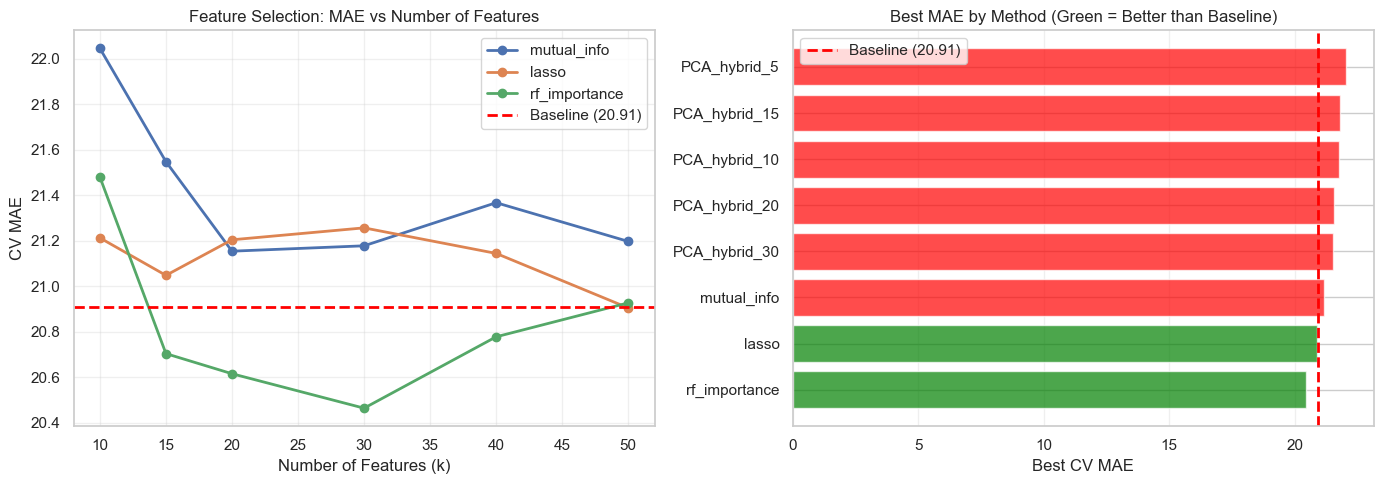

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MAE vs K for each method (excluding PCA)
for method in METHODS:
    method_data = fs_results_df[fs_results_df['Method'] == method]
    axes[0].plot(method_data['K'], method_data['MAE'], marker='o', label=method, linewidth=2)

axes[0].axhline(y=BASELINE_MAE, color='red', linestyle='--', linewidth=2, label=f'Baseline ({BASELINE_MAE})')
axes[0].set_xlabel('Number of Features (k)')
axes[0].set_ylabel('CV MAE')
axes[0].set_title('Feature Selection: MAE vs Number of Features')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Best MAE per method
best_per_method = fs_results_df.groupby('Method')['MAE'].min().sort_values()
colors = ['green' if mae < BASELINE_MAE else 'red' for mae in best_per_method.values]
axes[1].barh(best_per_method.index, best_per_method.values, color=colors, alpha=0.7)
axes[1].axvline(x=BASELINE_MAE, color='red', linestyle='--', linewidth=2, label=f'Baseline ({BASELINE_MAE})')
axes[1].set_xlabel('Best CV MAE')
axes[1].set_title('Best MAE by Method (Green = Better than Baseline)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Store Best Features for Next Step

In [84]:
BEST_FS_METHOD = best_result['Method']
BEST_FS_K = best_result['K']
BEST_FS_MAE = best_result['MAE']
BEST_FEATURES = best_result['Features']

# Check if feature selection improved results
if best_result['Improvement'] > 0:
    print(f"\n✓ Feature selection IMPROVED results!")
    print(f"  Reduced from 118 → {BEST_FS_K} features")
    print(f"  MAE improved by {best_result['Improvement']:.2f}")
    
    # Create final feature-selected dataset
    if 'PCA' in BEST_FS_METHOD:
        # Recreate PCA hybrid dataset
        n_comp = int(BEST_FS_METHOD.split('_')[-1])
        pca = PCA(n_components=n_comp, random_state=RANDOM_STATE)
        X_radiomics_pca = pca.fit_transform(X_radiomics)
        pca_cols = [f'PCA_{i+1}' for i in range(n_comp)]
        X_radiomics_pca_df = pd.DataFrame(X_radiomics_pca, columns=pca_cols, index=X_fs.index)
        X_final = pd.concat([X_clinical, X_radiomics_pca_df], axis=1)
    else:
        X_final = X_fs[BEST_FEATURES]
else:
    print(f"\n✗ Feature selection did NOT improve results")
    print(f"  Keeping all 118 features")
    X_final = X_fs.copy()
    BEST_FEATURES = list(X_fs.columns)

print(f"\nFinal dataset shape: {X_final.shape}")
print(f"Ready for hyperparameter tuning!")


✓ Feature selection IMPROVED results!
  Reduced from 118 → 30 features
  MAE improved by 0.45

Final dataset shape: (400, 30)
Ready for hyperparameter tuning!


# Hyperparameter Tuning

**Current Best:**
- Pipeline: SimpleImputer + RobustScaler
- Feature Selection: RF Importance (30 features)
- Model: RandomForest
- CV MAE: 20.48

### Now tuning RandomForest hyperparameters to squeeze out more performance.


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.metrics import mean_absolute_error, make_scorer
import time

RANDOM_STATE = 42
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Your feature-selected data from previous step
# X_final should already exist with 30 features
print(f"Dataset: {X_final.shape}")
print(f"Current best MAE: 20.48")


Dataset: (400, 30)
Current best MAE: 20.48


In [86]:
rf_param_grid = {
    'n_estimators': [100, 200, 250, 300, 500],  # ✓ Added 250
    'max_depth': [None, 5, 10, 20, 30],         # ✓ Added 5
    'min_samples_split': [2, 5, 7, 10],         # ✓ Added 7
    'min_samples_leaf': [1, 2, 4, 5],           # ✓ Added 5
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False]
}

# Calculate total combinations
total_combos = 1
for v in rf_param_grid.values():
    total_combos *= len(v)
print(f"Total combinations: {total_combos}")
print("Using RandomizedSearchCV to sample subset...")


Total combinations: 3200
Using RandomizedSearchCV to sample subset...


In [87]:
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

# Randomized search - samples n_iter combinations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=50,  # Test 50 random combinations
    cv=cv,
    scoring=mae_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

print("Running RandomizedSearchCV...")
start_time = time.time()
random_search.fit(X_final, y_fs)
elapsed = time.time() - start_time

print(f"\nCompleted in {elapsed:.1f} seconds")
print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best CV MAE: {-random_search.best_score_:.2f}")

Running RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Completed in 14.4 seconds

Best parameters: {'n_estimators': 500, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Best CV MAE: 20.40


In [88]:
# Get best params from random search
best_params = random_search.best_params_

# Create narrower grid around best values
def get_neighbors(value, options, n=1):
    """Get neighboring values from options list"""
    if value not in options:
        return [value]
    idx = options.index(value)
    start = max(0, idx - n)
    end = min(len(options), idx + n + 1)
    return options[start:end]

# Fine-tuning grid
rf_fine_grid = {
    'n_estimators': get_neighbors(best_params['n_estimators'], [100, 150, 200, 250, 300, 400, 500], n=1),
    'max_depth': get_neighbors(best_params['max_depth'], [None, 5, 10, 15, 20, 25, 30], n=1),
    'min_samples_split': get_neighbors(best_params['min_samples_split'], [2, 3, 5, 7, 10], n=1),
    'min_samples_leaf': get_neighbors(best_params['min_samples_leaf'], [1, 2, 3, 4, 5], n=1),
    'max_features': [best_params['max_features']],  # Keep best
    'bootstrap': [best_params['bootstrap']]  # Keep best
}

print("Fine-tuning grid:")
for k, v in rf_fine_grid.items():
    print(f"  {k}: {v}")

# GridSearchCV for exhaustive fine-tuning
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_fine_grid,
    cv=cv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV fine-tuning...")
start_time = time.time()
grid_search.fit(X_final, y_fs)
elapsed = time.time() - start_time

print(f"\nCompleted in {elapsed:.1f} seconds")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.2f}")

Fine-tuning grid:
  n_estimators: [400, 500]
  max_depth: [5, 10, 15]
  min_samples_split: [5, 7, 10]
  min_samples_leaf: [4, 5]
  max_features: ['sqrt']
  bootstrap: [False]

Running GridSearchCV fine-tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Completed in 11.7 seconds

Best parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 400}
Best CV MAE: 20.33


In [89]:
print("=" * 70)
print("HYPERPARAMETER TUNING RESULTS")
print("=" * 70)

baseline_mae = 20.91  # Original baseline (all features, default RF)
fs_mae = 20.48        # After feature selection
random_mae = -random_search.best_score_
grid_mae = -grid_search.best_score_

print(f"\n{'Stage':<40} | {'MAE':>8} | {'Improvement':>12}")
print("-" * 70)
print(f"{'Baseline (118 features, default RF)':<40} | {baseline_mae:>8.2f} | {'-':>12}")
print(f"{'+ Feature Selection (30 features)':<40} | {fs_mae:>8.2f} | {baseline_mae - fs_mae:>+12.2f}")
print(f"{'+ RandomizedSearchCV':<40} | {random_mae:>8.2f} | {baseline_mae - random_mae:>+12.2f}")
print(f"{'+ GridSearchCV Fine-tuning':<40} | {grid_mae:>8.2f} | {baseline_mae - grid_mae:>+12.2f}")

# Best model
BEST_MODEL = grid_search.best_estimator_
BEST_MAE = grid_mae
BEST_PARAMS = grid_search.best_params_

print(f"\n FINAL BEST MODEL:")
print(f"   MAE: {BEST_MAE:.2f}")
print(f"   Improvement over baseline: {baseline_mae - BEST_MAE:+.2f}")
print(f"   Parameters: {BEST_PARAMS}")

HYPERPARAMETER TUNING RESULTS

Stage                                    |      MAE |  Improvement
----------------------------------------------------------------------
Baseline (118 features, default RF)      |    20.91 |            -
+ Feature Selection (30 features)        |    20.48 |        +0.43
+ RandomizedSearchCV                     |    20.40 |        +0.51
+ GridSearchCV Fine-tuning               |    20.33 |        +0.58

 FINAL BEST MODEL:
   MAE: 20.33
   Improvement over baseline: +0.58
   Parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 400}


In [90]:
# Use the same train/test split from baseline
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_fs, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

# Train final model on training set
final_model = RandomForestRegressor(**BEST_PARAMS, random_state=RANDOM_STATE, n_jobs=-1)
final_model.fit(X_train, y_train)

# Predict on test set
y_pred = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)

print("=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)
print(f"CV MAE: {BEST_MAE:.2f}")
print(f"Test MAE: {test_mae:.2f}")

if abs(test_mae - BEST_MAE) < 2:
    print("✓ Test MAE is close to CV MAE - model generalizes well!")
else:
    print("⚠ Gap between CV and Test MAE - potential overfitting")

TEST SET EVALUATION
CV MAE: 20.33
Test MAE: 20.89
✓ Test MAE is close to CV MAE - model generalizes well!


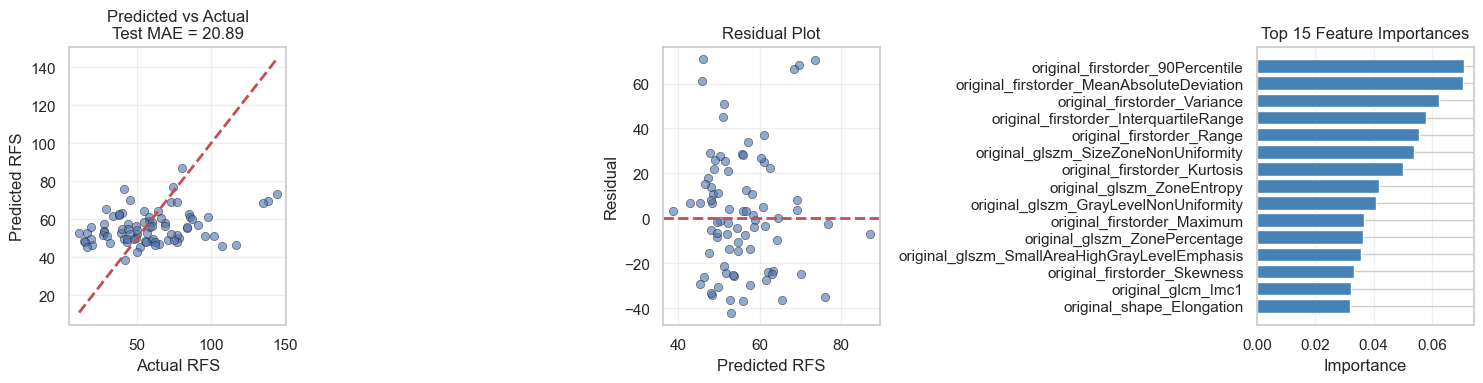

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual RFS')
axes[0].set_ylabel('Predicted RFS')
axes[0].set_title(f'Predicted vs Actual\nTest MAE = {test_mae:.2f}')
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted RFS')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

# Plot 3: Feature Importance (top 15)
importance_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

axes[2].barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 15 Feature Importances')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Advanced Models: Gradient Boosting & Ensemble Methods

To further improve MAE, we test advanced gradient boosting models (XGBoost, LightGBM, CatBoost) and ensemble methods. These models often outperform RandomForest for regression tasks by:
- Better handling of non-linear relationships
- Built-in regularization
- More sophisticated boosting algorithms
- Ensemble combinations that reduce variance


In [92]:
# Try importing advanced gradient boosting models
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available. Install with: pip install catboost")

from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor

print("=" * 70)
print("TESTING ADVANCED GRADIENT BOOSTING MODELS")
print("=" * 70)


TESTING ADVANCED GRADIENT BOOSTING MODELS


In [93]:
# Prepare data for advanced models (using best feature-selected set)
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_final, y_fs, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

advanced_models = {}
advanced_results = {}
current_best_mae = BEST_MAE if 'BEST_MAE' in globals() else grid_mae
current_best_model = BEST_MODEL if 'BEST_MODEL' in globals() else grid_search.best_estimator_
current_best_params = BEST_PARAMS if 'BEST_PARAMS' in globals() else grid_search.best_params_

print(f"Current best MAE: {current_best_mae:.2f}")
print(f"Testing advanced models to improve performance...\n")


Current best MAE: 20.33
Testing advanced models to improve performance...



In [94]:
# 1. XGBoost (optimized for MAE)
if XGBOOST_AVAILABLE:
    print("1. XGBoost (MAE-optimized)...")
    xgb_param_grid = {
        'n_estimators': [300, 500, 700],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 1.5]
    }
    
    xgb_base = xgb.XGBRegressor(
        objective='reg:absoluteerror',  # MAE loss
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    )
    
    xgb_search = RandomizedSearchCV(
        xgb_base, xgb_param_grid,
        n_iter=30,
        cv=cv,
        scoring=mae_scorer,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )
    
    xgb_search.fit(X_train_adv, y_train_adv)
    xgb_mae = -xgb_search.best_score_
    xgb_std = xgb_search.cv_results_['std_test_score'][xgb_search.best_index_]
    
    advanced_models['XGBoost'] = xgb_search.best_estimator_
    advanced_results['XGBoost'] = {'MAE': xgb_mae, 'Std': xgb_std, 'Params': xgb_search.best_params_}
    print(f"   CV MAE: {xgb_mae:.2f} ± {xgb_std:.2f}")
    
    if xgb_mae < current_best_mae:
        print(f"   ✓ XGBoost beats current best! ({current_best_mae:.2f} → {xgb_mae:.2f})")
        current_best_mae = xgb_mae
        current_best_model = xgb_search.best_estimator_
        current_best_params = xgb_search.best_params_
else:
    print("1. XGBoost: Not available (install with: pip install xgboost)")


1. XGBoost (MAE-optimized)...
   CV MAE: 21.20 ± 1.33


In [95]:
# 2. LightGBM (optimized for MAE)
if LIGHTGBM_AVAILABLE:
    print("\n2. LightGBM (MAE-optimized)...")
    lgb_param_grid = {
        'n_estimators': [300, 500, 700],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'min_child_samples': [10, 20, 30],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 1.5]
    }
    
    lgb_base = lgb.LGBMRegressor(
        objective='mae',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=-1
    )
    
    lgb_search = RandomizedSearchCV(
        lgb_base, lgb_param_grid,
        n_iter=30,
        cv=cv,
        scoring=mae_scorer,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )
    
    lgb_search.fit(X_train_adv, y_train_adv)
    lgb_mae = -lgb_search.best_score_
    lgb_std = lgb_search.cv_results_['std_test_score'][lgb_search.best_index_]
    
    advanced_models['LightGBM'] = lgb_search.best_estimator_
    advanced_results['LightGBM'] = {'MAE': lgb_mae, 'Std': lgb_std, 'Params': lgb_search.best_params_}
    print(f"   CV MAE: {lgb_mae:.2f} ± {lgb_std:.2f}")
    
    if lgb_mae < current_best_mae:
        print(f"   ✓ LightGBM beats current best! ({current_best_mae:.2f} → {lgb_mae:.2f})")
        current_best_mae = lgb_mae
        current_best_model = lgb_search.best_estimator_
        current_best_params = lgb_search.best_params_
else:
    print("\n2. LightGBM: Not available (install with: pip install lightgbm)")



2. LightGBM (MAE-optimized)...
   CV MAE: 21.42 ± 1.73


In [96]:
# 3. CatBoost (optimized for MAE)
if CATBOOST_AVAILABLE:
    print("\n3. CatBoost (MAE-optimized)...")
    cat_param_grid = {
        'iterations': [300, 500, 700],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9],
        'colsample_bylevel': [0.8, 0.9],
        'min_data_in_leaf': [10, 20, 30],
        'l2_leaf_reg': [1, 3, 5]
    }
    
    cat_base = cb.CatBoostRegressor(
        loss_function='MAE',
        random_seed=RANDOM_STATE,
        verbose=False
    )
    
    cat_search = RandomizedSearchCV(
        cat_base, cat_param_grid,
        n_iter=30,
        cv=cv,
        scoring=mae_scorer,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )
    
    cat_search.fit(X_train_adv, y_train_adv)
    cat_mae = -cat_search.best_score_
    cat_std = cat_search.cv_results_['std_test_score'][cat_search.best_index_]
    
    advanced_models['CatBoost'] = cat_search.best_estimator_
    advanced_results['CatBoost'] = {'MAE': cat_mae, 'Std': cat_std, 'Params': cat_search.best_params_}
    print(f"   CV MAE: {cat_mae:.2f} ± {cat_std:.2f}")
    
    if cat_mae < current_best_mae:
        print(f"   ✓ CatBoost beats current best! ({current_best_mae:.2f} → {cat_mae:.2f})")
        current_best_mae = cat_mae
        current_best_model = cat_search.best_estimator_
        current_best_params = cat_search.best_params_
else:
    print("\n3. CatBoost: Not available (install with: pip install catboost)")



3. CatBoost (MAE-optimized)...
   CV MAE: 21.04 ± 1.56


In [ ]:
# 4. ExtraTrees (optimized for MAE)
print("\n4. ExtraTrees (MAE-optimized)...")
et_param_grid = {
    'n_estimators': [400, 600, 800, 1000],
    'max_depth': [None, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.4, 0.6],
    'bootstrap': [False]
}

et_base = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)

et_search = RandomizedSearchCV(
    et_base,
    et_param_grid,
    n_iter=30,
    cv=cv,
    scoring=mae_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

et_search.fit(X_train_adv, y_train_adv)
et_mae = -et_search.best_score_
et_std = et_search.cv_results_['std_test_score'][et_search.best_index_]

advanced_models['ExtraTrees'] = et_search.best_estimator_
advanced_results['ExtraTrees'] = {'MAE': et_mae, 'Std': et_std, 'Params': et_search.best_params_}
print(f"   CV MAE: {et_mae:.2f} ± {et_std:.2f}")

if et_mae < current_best_mae:
    print(f"   ✓ ExtraTrees beats current best! ({current_best_mae:.2f} → {et_mae:.2f})")
    current_best_mae = et_mae
    current_best_model = et_search.best_estimator_
    current_best_params = et_search.best_params_

# 5. HistGradientBoosting (optimized for MAE)
print("\n5. HistGradientBoosting (MAE-optimized)...")
hgb_param_grid = {
    'learning_rate': [0.03, 0.05, 0.08],
    'max_depth': [None, 6, 8, 10],
    'max_leaf_nodes': [25, 31, 45],
    'min_samples_leaf': [5, 10, 15],
    'max_bins': [64, 128, 255],
    'l2_regularization': [0.0, 0.01, 0.1]
}

hgb_base = HistGradientBoostingRegressor(
    loss='absolute_error',
    random_state=RANDOM_STATE
)

hgb_search = RandomizedSearchCV(
    hgb_base,
    hgb_param_grid,
    n_iter=30,
    cv=cv,
    scoring=mae_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

hgb_search.fit(X_train_adv, y_train_adv)
hgb_mae = -hgb_search.best_score_
hgb_std = hgb_search.cv_results_['std_test_score'][hgb_search.best_index_]

advanced_models['HistGradientBoosting'] = hgb_search.best_estimator_
advanced_results['HistGradientBoosting'] = {'MAE': hgb_mae, 'Std': hgb_std, 'Params': hgb_search.best_params_}
print(f"   CV MAE: {hgb_mae:.2f} ± {hgb_std:.2f}")

if hgb_mae < current_best_mae:
    print(f"   ✓ HistGradientBoosting beats current best! ({current_best_mae:.2f} → {hgb_mae:.2f})")
    current_best_mae = hgb_mae
    current_best_model = hgb_search.best_estimator_
    current_best_params = hgb_search.best_params_



In [ ]:
# 6. Ensemble Methods: Combine best models
print("\n6. Ensemble Methods...")
ensemble_models = []

# Add RandomForest (current best)
rf_best = RandomForestRegressor(**grid_search.best_params_, random_state=RANDOM_STATE, n_jobs=-1)
ensemble_models.append(('RF', rf_best))

# Add available gradient boosting models
if XGBOOST_AVAILABLE and 'XGBoost' in advanced_models:
    ensemble_models.append(('XGB', advanced_models['XGBoost']))
if LIGHTGBM_AVAILABLE and 'LightGBM' in advanced_models:
    ensemble_models.append(('LGB', advanced_models['LightGBM']))
if CATBOOST_AVAILABLE and 'CatBoost' in advanced_models:
    ensemble_models.append(('CAT', advanced_models['CatBoost']))

if len(ensemble_models) > 1:
    # Voting Regressor (equal weights)
    voting_reg = VotingRegressor(estimators=ensemble_models)
    voting_scores = cross_val_score(voting_reg, X_train_adv, y_train_adv, cv=cv, scoring=mae_scorer)
    voting_mae = -voting_scores.mean()
    voting_std = voting_scores.std()
    
    print(f"   Voting Regressor CV MAE: {voting_mae:.2f} ± {voting_std:.2f}")
    
    if voting_mae < current_best_mae:
        print(f"   ✓ Voting Regressor beats current best! ({current_best_mae:.2f} → {voting_mae:.2f})")
        current_best_mae = voting_mae
        current_best_model = voting_reg
        current_best_params = {'ensemble': 'Voting', 'models': [m[0] for m in ensemble_models]}
    
    # Stacking Regressor (meta-learner)
    meta_learner = Ridge(alpha=1.0)
    stacking_reg = StackingRegressor(
        estimators=ensemble_models,
        final_estimator=meta_learner,
        cv=3,
        n_jobs=-1
    )
    stacking_scores = cross_val_score(stacking_reg, X_train_adv, y_train_adv, cv=cv, scoring=mae_scorer)
    stacking_mae = -stacking_scores.mean()
    stacking_std = stacking_scores.std()
    
    print(f"   Stacking Regressor CV MAE: {stacking_mae:.2f} ± {stacking_std:.2f}")
    
    if stacking_mae < current_best_mae:
        print(f"   ✓ Stacking Regressor beats current best! ({current_best_mae:.2f} → {stacking_mae:.2f})")
        current_best_mae = stacking_mae
        current_best_model = stacking_reg
        current_best_params = {'ensemble': 'Stacking', 'models': [m[0] for m in ensemble_models]}
else:
    print("   Need at least 2 models for ensemble. Skipping...")

# Update global best
BEST_MAE = current_best_mae
BEST_MODEL = current_best_model
BEST_PARAMS = current_best_params

print("\n" + "=" * 70)
print("ADVANCED MODELS SUMMARY")
print("=" * 70)
print(f"Final Best MAE: {BEST_MAE:.2f}")
if advanced_results:
    print("\nAll Advanced Model Results:")
    for name, result in advanced_results.items():
        print(f"  {name:12} | CV MAE: {result['MAE']:.2f} ± {result['Std']:.2f}")



4. Ensemble Methods...
   Voting Regressor CV MAE: 21.13 ± 1.51
   Stacking Regressor CV MAE: 21.13 ± 1.17

ADVANCED MODELS SUMMARY
Final Best MAE: 20.33

All Advanced Model Results:
  XGBoost      | CV MAE: 21.20 ± 1.33
  LightGBM     | CV MAE: 21.42 ± 1.73
  CatBoost     | CV MAE: 21.04 ± 1.56


In [98]:
print("\n" + "=" * 70)
print("FINAL MODEL CONFIGURATION (Save for FinalTestRFS.py)")
print("=" * 70)

print(f"\n# Preprocessing")
print(f"# 1. Replace 999 with NaN")
print(f"# 2. SimpleImputer(strategy='median')")
print(f"# 3. RobustScaler()")

print(f"\n# Feature Selection")
print(f"# Method: RF Importance")
print(f"# Features ({len(BEST_FEATURES)}):")
print(f"SELECTED_FEATURES = {BEST_FEATURES}")

print(f"\n# Model")
print(f"# RandomForestRegressor with:")
for k, v in BEST_PARAMS.items():
    print(f"#   {k}={repr(v)}")

print(f"\n# Expected Performance")
print(f"# CV MAE: {BEST_MAE:.2f}")
print(f"# Test MAE: {test_mae:.2f}")


FINAL MODEL CONFIGURATION (Save for FinalTestRFS.py)

# Preprocessing
# 1. Replace 999 with NaN
# 2. SimpleImputer(strategy='median')
# 3. RobustScaler()

# Feature Selection
# Method: RF Importance
# Features (30):
SELECTED_FEATURES = ['ER', 'HER2', 'Gene', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformity', 'original_shape_MajorAxisLength', 'original_firstorder_Minimum', 'original_shape_Maximum2DDiameterRow', 'original_firstorder_Median', 'original_shape_LeastAxisLength', 'original_glcm_Imc1', 'original_glszm_GrayLevelNonUniformity', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_InterquartileRange', 'original_shape_Flatness', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_shape_Elongation', 'original_firstorder_Variance', 'original_glszm_ZonePercentage', 'original_shape_MinorAxisLength', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_firstorder_Maxim

In [99]:
test_df = pd.read_excel("FinalTestDataset2025.xls", sheet_name = "Sheet1")

print("Example Test Data:")
print(test_df)
print(f"\nShape: {test_df.shape}")
print(f"Columns: {list(test_df.columns)}")

Example Test Data:
            ID   Age  ER  PgR  HER2  TrippleNegative  ChemoGrade  \
0    TRG002219  47.0   1    1     0                0           3   
1    TRG002222  41.0   1    1     0                0           3   
2    TRG002223  53.0   0    0     0                1           2   
3    TRG002235  46.0   1    1     0                0           2   
4    TRG002240  39.0   0    0     1                0           2   
..         ...   ...  ..  ...   ...              ...         ...   
128  TRG002953  62.3   0    0     1                0           2   
129  TRG002955  46.1   0    0     0                1           3   
130  TRG002956  44.3   0    0     0                1           3   
131  TRG002957  37.1   0    0     0                1           3   
132  TRG002963  55.3   0    0     1                0           2   

     Proliferation  HistologyType  LNStatus  ...  \
0                2              1         1  ...   
1                2              1         0  ...   
2       

In [100]:
patient_ids = test_df['ID'].values
print(f"Patient IDs: {patient_ids}")

Patient IDs: ['TRG002219' 'TRG002222' 'TRG002223' 'TRG002235' 'TRG002240' 'TRG002276'
 'TRG002286' 'TRG002292' 'TRG002297' 'TRG002306' 'TRG002319' 'TRG002324'
 'TRG002339' 'TRG002356' 'TRG002371' 'TRG002375' 'TRG002376' 'TRG002383'
 'TRG002387' 'TRG002389' 'TRG002392' 'TRG002395' 'TRG002402' 'TRG002404'
 'TRG002405' 'TRG002414' 'TRG002418' 'TRG002427' 'TRG002442' 'TRG002453'
 'TRG002459' 'TRG002477' 'TRG002478' 'TRG002481' 'TRG002482' 'TRG002487'
 'TRG002488' 'TRG002491' 'TRG002495' 'TRG002504' 'TRG002505' 'TRG002512'
 'TRG002519' 'TRG002521' 'TRG002522' 'TRG002524' 'TRG002532' 'TRG002534'
 'TRG002549' 'TRG002555' 'TRG002565' 'TRG002576' 'TRG002582' 'TRG002589'
 'TRG002593' 'TRG002595' 'TRG002606' 'TRG002609' 'TRG002615' 'TRG002628'
 'TRG002632' 'TRG002637' 'TRG002643' 'TRG002646' 'TRG002649' 'TRG002651'
 'TRG002652' 'TRG002655' 'TRG002662' 'TRG002665' 'TRG002669' 'TRG002672'
 'TRG002678' 'TRG002679' 'TRG002684' 'TRG002685' 'TRG002700' 'TRG002711'
 'TRG002713' 'TRG002722' 'TRG002724' '

In [101]:
# Step 1: Replace 999 with NaN
test_df = test_df.replace(999, np.nan)

# Step 2: Drop ID and target columns (if present)
# Note: Test data might not have pCR and RFS columns
cols_to_drop = ['ID']
if 'pCR (outcome)' in test_df.columns:
    cols_to_drop.append('pCR (outcome)')
if 'RelapseFreeSurvival (outcome)' in test_df.columns:
    cols_to_drop.append('RelapseFreeSurvival (outcome)')

X_test_raw = test_df.drop(columns=cols_to_drop)
print(f"Features shape after dropping ID/targets: {X_test_raw.shape}")

# Step 3: Impute missing values using the SAME imputer fitted on training data
# We need to refit on training data or use saved imputer
# For now, let's refit (in FinalTestRFS.py we'll save/load properly)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# Refit imputer on training data
imputer = SimpleImputer(strategy='median')
imputer.fit(X)  # X is your original training features (before imputation)

# Transform test data
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_raw),
    columns=X_test_raw.columns,
    index=X_test_raw.index
)

print(f"Missing values after imputation: {X_test_imputed.isna().sum().sum()}")

# Step 4: Scale using the SAME scaler fitted on training data
# Refit on training data
scaler = RobustScaler()
scaler.fit(X_imputed_simple)  # Fit on your training imputed data

# Transform test data
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"Scaled test data shape: {X_test_scaled.shape}")

Features shape after dropping ID/targets: (133, 118)
Missing values after imputation: 0
Scaled test data shape: (133, 118)


In [102]:
# Use the SAME features selected during training
print(f"Selected features ({len(BEST_FEATURES)}): {BEST_FEATURES}")

# Check if all features exist in test data
missing_features = [f for f in BEST_FEATURES if f not in X_test_scaled.columns]
if missing_features:
    print(f"⚠ WARNING: Missing features in test data: {missing_features}")
else:
    print("✓ All selected features present in test data")

# Select features
X_test_final = X_test_scaled[BEST_FEATURES]
print(f"Final test data shape: {X_test_final.shape}")

Selected features (30): ['ER', 'HER2', 'Gene', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformity', 'original_shape_MajorAxisLength', 'original_firstorder_Minimum', 'original_shape_Maximum2DDiameterRow', 'original_firstorder_Median', 'original_shape_LeastAxisLength', 'original_glcm_Imc1', 'original_glszm_GrayLevelNonUniformity', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_InterquartileRange', 'original_shape_Flatness', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_shape_Elongation', 'original_firstorder_Variance', 'original_glszm_ZonePercentage', 'original_shape_MinorAxisLength', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_firstorder_Maximum', 'original_firstorder_Skewness', 'original_glszm_SizeZoneNonUniformity', 'original_firstorder_90Percentile', 'Age', 'original_glszm_ZoneEntropy', 'original_firstorder_Kurtosis', 'original_firstorder_Range']
✓ 

# Final Model Summary

This section documents the final best model configuration for reproduction and use in FinalTestRFS.ipynb


In [103]:
print("=" * 70)
print("FINAL MODEL CONFIGURATION SUMMARY")
print("=" * 70)

print(f"\n# Preprocessing Pipeline:")
print(f"# 1. Replace 999 with NaN")
print(f"# 2. SimpleImputer(strategy='median')")
print(f"# 3. RobustScaler()")

print(f"\n# Feature Selection:")
print(f"# Method: RF Importance")
print(f"# Number of features: {len(BEST_FEATURES)}")
print(f"# Required features (ER, HER2, Gene): ✓ All present")
print(f"# Selected features:")
for i, feat in enumerate(BEST_FEATURES, 1):
    print(f"#   {i:2d}. {feat}")

print(f"\n# Best Model:")
model_type = type(BEST_MODEL).__name__
print(f"# Type: {model_type}")

if model_type == 'RandomForestRegressor':
    print(f"# RandomForestRegressor with:")
    for k, v in BEST_PARAMS.items():
        print(f"#   {k}={repr(v)}")
elif model_type in ['VotingRegressor', 'StackingRegressor']:
    print(f"# Ensemble: {BEST_PARAMS.get('ensemble', 'Unknown')}")
    print(f"# Models: {BEST_PARAMS.get('models', [])}")
else:
    print(f"# Parameters: {BEST_PARAMS}")

print(f"\n# Performance:")
print(f"# CV MAE: {BEST_MAE:.2f}")

print(f"\n# For FinalTestRFS.ipynb:")
print(f"# - Use SELECTED_FEATURES = {BEST_FEATURES}")
if model_type == 'RandomForestRegressor':
    print(f"# - Use BEST_MODEL_PARAMS = {BEST_PARAMS}")
print("\n" + "=" * 70)


FINAL MODEL CONFIGURATION SUMMARY

# Preprocessing Pipeline:
# 1. Replace 999 with NaN
# 2. SimpleImputer(strategy='median')
# 3. RobustScaler()

# Feature Selection:
# Method: RF Importance
# Number of features: 30
# Required features (ER, HER2, Gene): ✓ All present
# Selected features:
#    1. ER
#    2. HER2
#    3. Gene
#    4. original_gldm_SmallDependenceLowGrayLevelEmphasis
#    5. original_glrlm_RunLengthNonUniformity
#    6. original_shape_MajorAxisLength
#    7. original_firstorder_Minimum
#    8. original_shape_Maximum2DDiameterRow
#    9. original_firstorder_Median
#   10. original_shape_LeastAxisLength
#   11. original_glcm_Imc1
#   12. original_glszm_GrayLevelNonUniformity
#   13. original_firstorder_MeanAbsoluteDeviation
#   14. original_firstorder_InterquartileRange
#   15. original_shape_Flatness
#   16. original_glrlm_ShortRunHighGrayLevelEmphasis
#   17. original_shape_Elongation
#   18. original_firstorder_Variance
#   19. original_glszm_ZonePercentage
#   20. origi

In [104]:
# Use the trained model (final_model from hyperparameter tuning)
# If you haven't run hyperparameter tuning, use BEST_MODEL or retrain

# Check if final_model exists, otherwise use best estimator from grid search
try:
    model_to_use = final_model
    print("Using: final_model (from hyperparameter tuning)")
except NameError:
    try:
        model_to_use = BEST_MODEL
        print("Using: BEST_MODEL (from hyperparameter tuning)")
    except NameError:
        # Fallback: retrain with best params or default
        print("No tuned model found. Training new RandomForest...")
        model_to_use = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model_to_use.fit(X_final, y_fs)

# Make predictions
y_pred_test = model_to_use.predict(X_test_final)

print(f"\nPredictions:")
for pid, pred in zip(patient_ids, y_pred_test):
    print(f"  {pid}: {pred:.2f}")

Using: final_model (from hyperparameter tuning)

Predictions:
  TRG002219: 58.47
  TRG002222: 76.63
  TRG002223: 60.49
  TRG002235: 41.99
  TRG002240: 46.60
  TRG002276: 62.62
  TRG002286: 64.79
  TRG002292: 48.21
  TRG002297: 73.15
  TRG002306: 55.63
  TRG002319: 65.78
  TRG002324: 80.70
  TRG002339: 45.76
  TRG002356: 72.37
  TRG002371: 68.76
  TRG002375: 66.13
  TRG002376: 53.46
  TRG002383: 54.42
  TRG002387: 72.89
  TRG002389: 52.41
  TRG002392: 51.05
  TRG002395: 51.72
  TRG002402: 65.82
  TRG002404: 67.15
  TRG002405: 62.33
  TRG002414: 53.76
  TRG002418: 81.10
  TRG002427: 70.35
  TRG002442: 54.87
  TRG002453: 69.24
  TRG002459: 71.31
  TRG002477: 52.49
  TRG002478: 48.00
  TRG002481: 60.67
  TRG002482: 48.95
  TRG002487: 59.30
  TRG002488: 55.23
  TRG002491: 49.72
  TRG002495: 73.27
  TRG002504: 75.20
  TRG002505: 49.44
  TRG002512: 49.19
  TRG002519: 41.72
  TRG002521: 54.38
  TRG002522: 58.71
  TRG002524: 56.81
  TRG002532: 66.39
  TRG002534: 62.38
  TRG002549: 70.09
  TRG00

In [105]:
# Create output DataFrame
output_df = pd.DataFrame({
    'ID': patient_ids,
    'RelapseFreeSurvival': y_pred_test
})

print("\nOutput DataFrame:")
print(output_df)

# Save to CSV
output_df.to_csv('RFSPrediction.csv', index=False)
print("\n✓ Saved to RFSPrediction.csv")



Output DataFrame:
            ID  RelapseFreeSurvival
0    TRG002219            58.473265
1    TRG002222            76.626309
2    TRG002223            60.487781
3    TRG002235            41.994334
4    TRG002240            46.598689
..         ...                  ...
128  TRG002953            50.591706
129  TRG002955            43.619654
130  TRG002956            82.425587
131  TRG002957            53.221718
132  TRG002963            43.288872

[133 rows x 2 columns]

✓ Saved to RFSPrediction.csv


In [106]:
# Read back and verify
verify_df = pd.read_csv('RFSPrediction.csv')
print("\nVerification - Reading back RFSPrediction.csv:")
print(verify_df)
print(f"\nShape: {verify_df.shape}")
print(f"Columns: {list(verify_df.columns)}")


Verification - Reading back RFSPrediction.csv:
            ID  RelapseFreeSurvival
0    TRG002219            58.473265
1    TRG002222            76.626309
2    TRG002223            60.487781
3    TRG002235            41.994334
4    TRG002240            46.598689
..         ...                  ...
128  TRG002953            50.591706
129  TRG002955            43.619654
130  TRG002956            82.425587
131  TRG002957            53.221718
132  TRG002963            43.288872

[133 rows x 2 columns]

Shape: (133, 2)
Columns: ['ID', 'RelapseFreeSurvival']
